# Bulk Analysis
Here is the analysis of the bulk RNA-sequencing data we performed on PBMCs from 3 individuals, profiling their expression under stimulation of 5 molecules (IFN-gamma, IFN-beta, PMA/Ionomycin, R848, and TNF-alpha) at 5 time points (0, 3, 6, 9, and 12) hours.

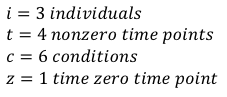

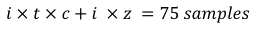

### Load in packages

Some standard ones here:

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy

And then some from the [goatools](https://github.com/tanghaibao/goatools) Gene Ontology package for Python. Most of the code here modeled after the [notebooks](https://github.com/tanghaibao/goatools#ipython-notebooks) found on the Github.

In [2]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_hum
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

Some nice parameters I like, stolen from Scanpy:

In [3]:
fontsize = 14

In [4]:
rcParams['figure.figsize'] = (4, 4)
rcParams['figure.dpi'] = 80
rcParams['figure.subplot.left'] = 0.18
rcParams['figure.subplot.right'] = 0.96
rcParams['figure.subplot.bottom'] = 0.15
rcParams['figure.subplot.top'] = 0.91

rcParams['lines.linewidth'] = 1.5  # the line width of the frame
rcParams['lines.markersize'] = 6
rcParams['lines.markeredgewidth'] = 1

# font
rcParams['font.sans-serif'] = [
'Arial',
'Helvetica',
'DejaVu Sans',
'Bitstream Vera Sans',
'sans-serif',
]
fontsize = fontsize
rcParams['font.size'] = fontsize
rcParams['legend.fontsize'] = 0.92 * fontsize
rcParams['axes.titlesize'] = fontsize
rcParams['axes.labelsize'] = fontsize

# legend
rcParams['legend.numpoints'] = 1
rcParams['legend.scatterpoints'] = 1
rcParams['legend.handlelength'] = 0.5
rcParams['legend.handletextpad'] = 0.4

# lines
rcParams['axes.linewidth'] = 0.8
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'

# ticks
rcParams['xtick.color'] = 'k'
rcParams['ytick.color'] = 'k'
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

# axes grid
rcParams['axes.grid'] = True
rcParams['grid.color'] = '.8'

Define a path prefix:

In [5]:
prefix = '/data/codec/bulk.jan20/' # path to the dir holding all relevant files

### Read in files

I have a separate notebook that creates a dictinoary to map ENSG IDs to gene names. I load that in here:

In [6]:
with open(prefix + "ensgdict.pkl", 'rb') as file:
    ensgdict = pkl.load(file)

Quick check on the dictionary to see that it looks good.

In [7]:
print(list(ensgdict.keys())[:5])
print(list(ensgdict.values())[:5])

['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945']
['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']


Run some bash commands to read all the file names in the `read.counts` directory, holding the counts from `htseq-count`.

In [8]:
fns = !ls -1 {prefix}"read.counts/"

Extract out sample names:

In [9]:
samples = list()
for fn in fns:
    samples.append(fn.split('_')[0].split('-')) # this parses the file names, I named them in a systematic way
samples = np.unique(np.array(samples).flatten())

In [10]:
samples

array(['0HR', '12HR', '1895', '2061', '3HR', '6HR', '731', '9HR',
       'Control', 'IFNB', 'IFNG', 'None', 'PMAI', 'R848', 'TNFa'],
      dtype='<U7')

Create a `pd.MultiIndex`, very useful in these cases of multiple variables defining each individual row. I only do the non-zero time point here because the 0 hour time point had only 3 samples. Generating with `.from_product` would make superfluous indices.

In [11]:
multidx = pd.MultiIndex.from_product([['731', '1895', '2061'],['3HR','6HR','9HR','12HR'],['Control', 'IFNB', 'IFNG', 'PMAI', 'R848', 'TNFa']])

Now add in those 3 time zero time points.

In [12]:
multidx = multidx.insert(0, ('731', '0HR', 'None'))
multidx = multidx.insert(25, ('1895', '0HR', 'None'))
multidx = multidx.insert(50, ('2061', '0HR', 'None'))

Read in the read counts into a list of dataframes.

In [13]:
dfs = list()
for fn in tqdm(fns):
    df = pd.read_csv(prefix + "read.counts/" + fn, sep='\t', header=None).set_index(0).T
    df.index.name = 'sample'
    df.index = [tuple(fn.split('_')[0].split('-'))]
    dfs.append(df)

In [14]:
dfs[0]

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000285492,ENSG00000285505,ENSG00000285508,ENSG00000285509,ENSG00000285513,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique
"(1895, 0HR, None)",12,0,106,54,0,1879,4,117,105,86,...,10,0,0,0,0,3813417,104400,0,0,4017668


After trying multiple times, I can't figure out which values (or sum thereof) in the `htseq-count` output corresponds to total library size. So I just got total reads from the original fastqs and put all the total read counts in a single file. Reading it in here:

In [15]:
with open(prefix + 'totreadscounts.txt','r') as file:
    lines = file.readlines()
    libreads = dict([(tuple(j[0].split("-")), int(j[1])) for j in [i.strip().split(",") for i in lines]])

# I want the timepoint as an integer
# I couldn't figure out how to adjust this inplace, so just building a new one

_libreads = dict()
for i in libreads:
    _libreads[tuple([i[0],i[1].strip('HR'),i[2]])] = libreads[i]
libreads = _libreads

### Build the Big Counts Matrix

Building a `pd.DataFrame` with the counts from all samples.

In [16]:
counts = dict()

In [17]:
counts['raw'] = pd.concat(dfs)

Make the index a `pd.Multiindex`.

In [18]:
counts['raw'].index = pd.MultiIndex.from_tuples([(i[0],i[1].strip('HR'), i[2]) for i in counts['raw'].index.values])

In [19]:
counts['raw'].index.names = ['IND','TIME','STIM']

Now would be a good time to define some useful variables:

In [20]:
stims = ['IFNG','IFNB','PMAI','R848','TNFa'] # I wish I made TNFa TNFA for consistency
hours = ['3','6','9','12']
tests = ['TC'] + hours
inds=['1895','2061','731']

Remap all the ENSG ids to their actual gene name.

In [21]:
newcols = counts['raw'].columns.map(ensgdict).tolist()
newcols[-5:] = counts['raw'].columns[-5:]

In [22]:
counts['raw'].columns = newcols

In [23]:
counts['raw']

TSPAN6  TNMD  DPM1  SCYL3  C1orf112   FGR  CFH  FUCA2  \
IND  TIME STIM                                                             
1895 0    None         12     0   106     54         0  1879    4    117   
     12   Control       4     0   167    122         2   230    0     64   
          IFNB          2     0   179     92         7   174    5     76   
          IFNG          7     0   187    193         9   647   12     71   
          PMAI         13     0   547     58         4   248    0     22   
...                   ...   ...   ...    ...       ...   ...  ...    ...   
731  9    IFNB          3     0    92     63        11   125    0     15   
          IFNG          4     0   238    200         7   574    8     26   
          PMAI          0     0   334     43         0   839    9      6   
          R848          2     0   259    226        19   198    6     12   
          TNFa          6     0   252    184        20   508    3     59   

                   GCLC  NFYA  ...  AL356417.3  AC010616.2  AL034430.1  \
IND  TIME STIM                 ...                                       
1895 0    None      105    86  ...          10           0           0   
     12   Control   477    86  ...           0           0           0   
          IFNB      316   111  ...           0           0           0   
          IFNG      836    69  ...           0           0           0   
          PMAI      215   138  ...           0           0           0   
...                 ...   ...  ...         ...         ...         ...   
731  9    IFNB      204    63  ...           0           0           0   
          IFNG      672    68  ...           0           0           0   
          PMAI      247   134  ...           4           0           0   
          R848      211    62  ...           1           0           0   
          TNFa      347    52  ...           0           0           0   

                   AP000646.1  AP006216.3  __no_feature  __ambiguous  \
IND  TIME STIM                                                         
1895 0    None              0           0       3813417       104400   
     12   Control           0           0       2218082        87556   
          IFNB              0           0       1893717        85918   
          IFNG              0           0       2955527       137238   
          PMAI              0           0       2329449       101390   
...                       ...         ...           ...          ...   
731  9    IFNB              0           0       1657083        65585   
          IFNG              0           0       2748356       103415   
          PMAI              0           0       2802613        91004   
          R848              0           0       3864753       131514   
          TNFa              0           0       3401409       113479   

                   __too_low_aQual  __not_aligned  __alignment_not_unique  
IND  TIME STIM                                                             
1895 0    None                   0              0                 4017668  
     12   Control                0              0                 2633375  
          IFNB                   0              0                 2366138  
          IFNG                   0              0                 3947510  
          PMAI                   0              0                 3612969  
...                            ...            ...                     ...  
731  9    IFNB                   0              0                 2190246  
          IFNG                   0              0                 3985939  
          PMAI                   0              0                 4059545  
          R848                   0              0                 5261412  
          TNFa                   0              0                 5125559  

[75 rows x 33543 columns]

At this point, I'm going to export to a pickle to load into a separate notebook to prepare the raw counts `df` for DESeq2. I run DESeq2 in yet another notebook, and then load the files in here further down in this notebook.

In [24]:
# with open(prefix + "counts.pkl", "wb") as file:
#     pkl.dump(counts, file)

In [25]:
with open(prefix + "counts.pkl", "rb") as file:
    counts = pd.read_pickle(file)

Now that just the raw read counts files are exported, I'd like to separate out some of the meta data from the `htseq-count` output.

In [26]:
counts['meta'] = counts['raw'].iloc[:,-5:] # only the last 5 columns contain metadata
counts['raw'] = counts['raw'].iloc[:,:-5]

counts['meta'].columns = [i.strip("__") for i in counts['meta'].columns] # get rid of the double underscore at the beginning, it has no use as far as I can see

I would like to add my `libreads` data to `counts[meta]`.

In [27]:
s = pd.Series(libreads)
s.index.names = ['IND','TIME','STIM'] # need to give the index names so they match up to the right ones in counts[meta]
counts['meta']['tot_reads'] = s

In [28]:
counts['meta']

no_feature  ambiguous  too_low_aQual  not_aligned  \
IND  TIME STIM                                                         
1895 0    None        3813417     104400              0            0   
     12   Control     2218082      87556              0            0   
          IFNB        1893717      85918              0            0   
          IFNG        2955527     137238              0            0   
          PMAI        2329449     101390              0            0   
...                       ...        ...            ...          ...   
731  9    IFNB        1657083      65585              0            0   
          IFNG        2748356     103415              0            0   
          PMAI        2802613      91004              0            0   
          R848        3864753     131514              0            0   
          TNFa        3401409     113479              0            0   

                   alignment_not_unique  tot_reads  
IND  TIME STIM                                      
1895 0    None                  4017668   15056748  
     12   Control               2633375    9990474  
          IFNB                  2366138    8809236  
          IFNG                  3947510   14037893  
          PMAI                  3612969   12776156  
...                                 ...        ...  
731  9    IFNB                  2190246    7751220  
          IFNG                  3985939   12765986  
          PMAI                  4059545   13111938  
          R848                  5261412   17304522  
          TNFa                  5125559   15290556  

[75 rows x 6 columns]

### Plotting of Meta Data

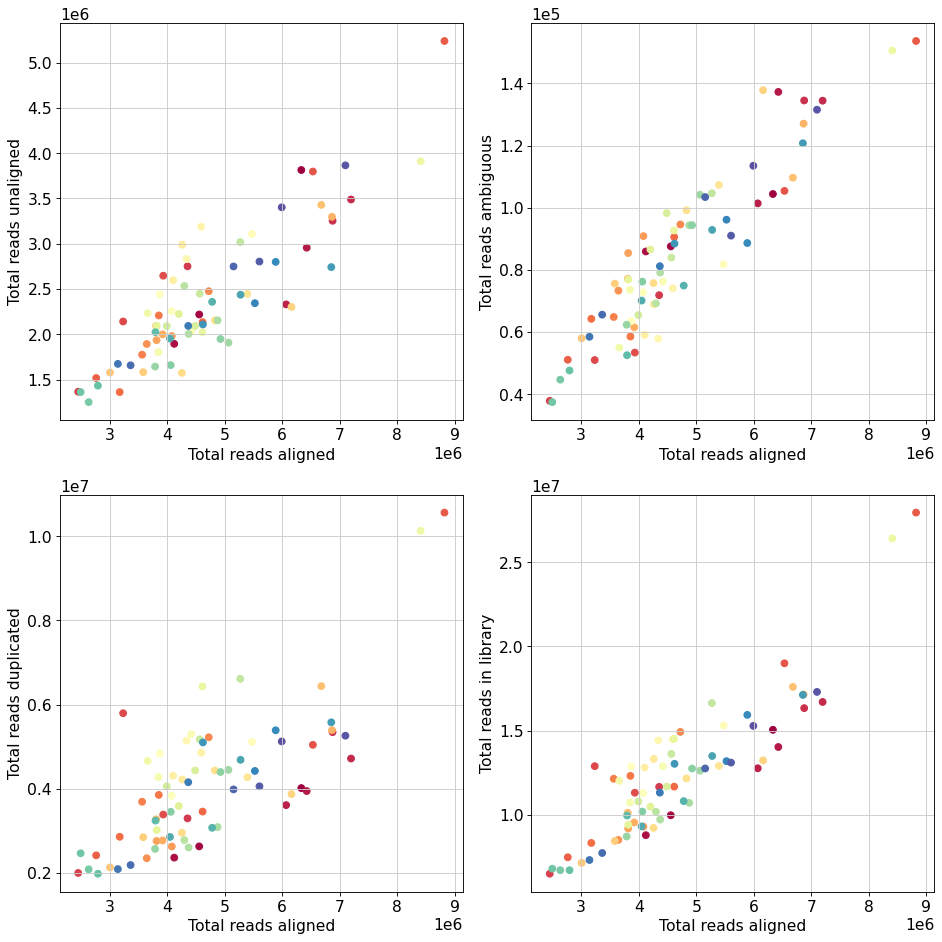

In [29]:
fig, ax = plt.subplots(2,2,figsize=(12,12)) # make a figure with 4 sub plots
colormap = plt.cm.Spectral # use this greate colormap that can better differentiate our many samples
cs = [colormap(i) for i in np.linspace(0, 1, counts['raw'].shape[0])] # get colors mapped linearly from the colormap 

# zip the columns of the data (and theyre label in the plot) with the axes from the subplots
for data, ax in zip([('no_feature', 'unaligned'), 
                     ('ambiguous', 'ambiguous'),
                     ('alignment_not_unique', 'duplicated'),
                     ('tot_reads', 'in library')
                    ], np.ravel(ax)):
    
    ax.scatter(counts['raw'].sum(axis=1).values,
               counts['meta'][data[0]],c=cs);
    
    ax.set_xlabel('Total reads aligned')
    ax.set_ylabel('Total reads %s' % data[1]);
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()

### Make a Normalized Counts Matrix

DESeq2 is *likely* normalizing by the sum of the read counts from just the genes. Although I've showed all of these things correlate with each other above, I think its more proper to normalize by the total reads in the library. Unfortunately I don't think it's worth trying to figure out how to input total reads in DESeq2 to normalize by, but I still think the results from DESeq2 are still valid. However, for my own purposes in this notebook below (mostly just calculating mean expression across genes) I will normalize by total reads in library (from the raw fastqs).

In [30]:
counts['raw'] = counts['raw'].astype(np.float128) # retype the raw counts as a high-precision float

In [31]:
counts['norm'] = counts['raw'].div(counts['meta']['tot_reads'].values, axis=0) # divide by the total reads

Now they're *technically* normalized, but the expression values for any individual gene are extremely small percentages. To bring them back into the "integer" realm of real numbers, I will take the smallest non-zero value in the entire matrix and divide all values by this. Now, zero counts are still zero, the smallest non-zero count is 1, and everything that had proportionally more counts than that is some real number above 1.

In [32]:
nonzero_min = counts['norm'].values.flatten()[(counts['norm'].values > 0).flatten()].min()
counts['norm'] = counts['norm'].div(nonzero_min) # could take a bit

Also going to make a log fold change matrix as well, for use later:

In [33]:
for cond in ['TNFa','IFNB','IFNG','R848','PMAI']:
    print(cond)
#     counts['norm']

TNFa
IFNB
IFNG
R848
PMAI


In [34]:
norm_lfc = list()
for ind, hour in it.product(inds, hours):
    df = counts['norm'].xs([hour,ind], level=['TIME','IND']) + 1 # +1 to avoid NaNs
    for stim in stims:
        row = [ind, hour, stim] + np.log2(np.divide((df).loc[stim], (df).loc['Control'])).values.tolist()
        norm_lfc.append(row)

In [35]:
counts['norm_lfc'] = pd.DataFrame(data=norm_lfc,columns=['IND','TIME','STIM'] + counts['norm'].columns.tolist())

In [36]:
norm_lfc = list()
for ind, hour in it.product(inds, hours):
    df = counts['raw'].xs([hour,ind], level=['TIME','IND']) + 1 # +1 to avoid NaNs
    for stim in stims:
        row = [ind, hour, stim] + np.log2(np.divide((df).loc[stim], (df).loc['Control'])).values.tolist()
        norm_lfc.append(row)

In [37]:
counts['raw_lfc'] = pd.DataFrame(data=norm_lfc,columns=['IND','TIME','STIM'] + counts['raw'].columns.tolist())

In [38]:
counts['norm_lfc'].index = pd.MultiIndex.from_frame(counts['norm_lfc'][['IND','TIME','STIM']])
counts['norm_lfc'].drop(columns=['IND','TIME','STIM'], inplace=True)

In [39]:
counts['raw_lfc'].index = pd.MultiIndex.from_frame(counts['raw_lfc'][['IND','TIME','STIM']])
counts['raw_lfc'].drop(columns=['IND','TIME','STIM'], inplace=True)

### Load in DESeq2 Results

As mentioned, I ran DESeq2 in a separate notebook. I ran two tests, one that just compares every stim to the control for every non-zero time point (labeled by the hour in the cell below), and another that tries to model stimulation-specific changes over time (labeled as TC below). I'll read in all, but since I'm not *exactly* sure how to interpret the latter, I'm really only going to focus on the former in this notebook.

Read in the results.

In [40]:
de = dict() # differential expression dictionary
for stim in stims:
    de[stim] = dict()
    
combos = it.product(stims, tests)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

## DE Genes: Upregulated

Just focusing on those genes that were increased in expression relatively to control. Using the 90th percentile positive log2fc and the p_adj < 0.05, I will extract out differentially expressed genes.

In [41]:
#########################################################################################################
# Through testing with multiple samples, I think a good metric for determining differentially expressed genes involves a strict p_adj value cutoff (0.05) 
# and a dynamic log fold change threshold that changes depending on the sample. I'm using the log2foldchange value at the 90th %ile of positive values
#########################################################################################################

de_genes = dict() # make a dictionary

for stim in stims:
    de_genes[stim] = dict() # each value will be each stim, itself be a dictionary with values of hours

# for each stim, each non-zero hour...
combos = list(it.product(stims, hours)) 
for combo in combos: 
    stim = combo[0]
    hour = combo[1]
    df = de[stim][hour] # get the DE results
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[stim][hour] = df.index[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.05)
                                   ].tolist() 

### Plot The Positive Half of the Volcano Plot for Any Sample

In [42]:
stim = 'R848'
hour = '12'

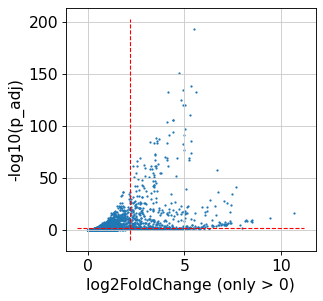

In [43]:
df = de[stim][hour]
df = df[df['log2FoldChange'] > 0]
fc_thresh = np.percentile(df['log2FoldChange'],90)

plt.scatter(df['log2FoldChange'].values, 
            -np.log10(df['padj']).values,
           s=1);

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

# drawing cutoffs here
plt.plot(xlim, [-np.log10(0.05)]*2, linewidth=1, c='r', linestyle='--');
plt.plot([fc_thresh]*2, ylim, linewidth=1, c='r', linestyle='--');

plt.xlabel('log2FoldChange (only > 0)')
plt.ylabel('-log10(p_adj)');

Get the number of genes that were differentially expressed in each sample.

In [44]:
num_genes = pd.DataFrame(index=stims, columns=hours)
for i in de_genes:
    for j in de_genes[i]:
        num_genes.loc[i, j] = len(de_genes[i][j])

In [45]:
num_genes

,3,6,9,12
IFNG,270,308,267,343
IFNB,388,429,305,358
PMAI,428,426,455,457
R848,409,417,379,430
TNFa,128,179,155,119


### Build the Jaccard Index of Gene Sets

The Jaccard index is the length of the intersection over the union of two sets of items. Shows us how similar the gene sets are.

In [46]:
# build an "overlap" DataFrame
overlap = pd.DataFrame(np.zeros((len(combos),len(combos))), index=combos, columns=combos)

In [47]:
# for each combination of combinations (of stim-hours)...
for c_c in tqdm(it.product(combos,repeat=2)):
    c0 = c_c[0]
    c1 = c_c[1]
    
    g0 = de_genes[c0[0]][c0[1]] # get the de genes from stim-hour one
    g1 = de_genes[c1[0]][c1[1]] # get the de genes from stim-hour two
    
    # fill in the dataframe with the jaccard index
    overlap.loc[c0, c1] = len(np.intersect1d(g0, g1))/len(np.union1d(g0, g1))
    

The Jaccard Index similarity matrix should be symmetrical. Therefore, the lower half of the triangle is redundant. For that reason, I'll build a mask to hide the lower triangle.

In [48]:
mask = ~np.triu(np.ones_like(overlap.values, dtype=np.bool), k=0)

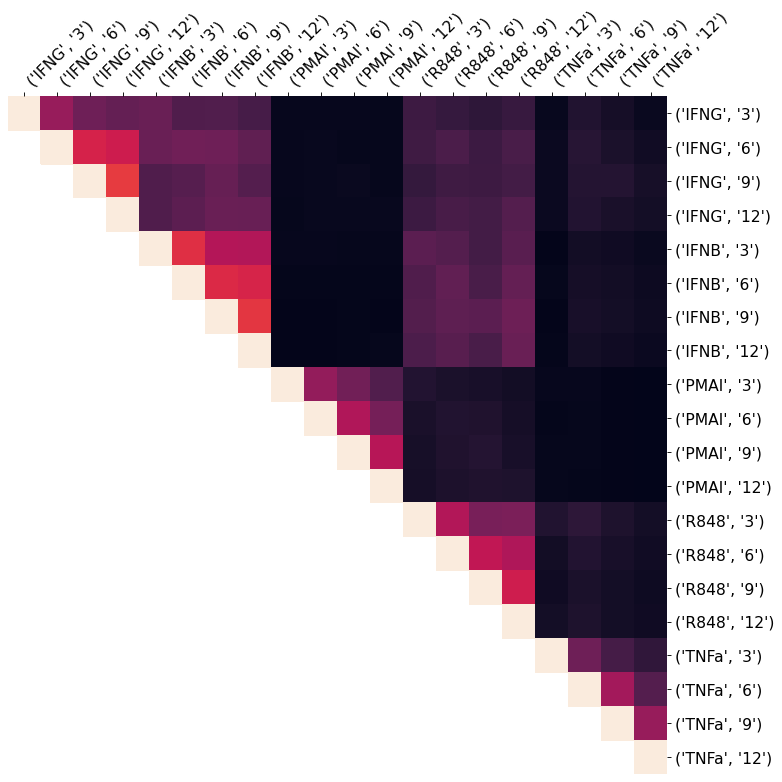

In [49]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.xaxis.tick_top()
ax.yaxis.tick_right()
sns.heatmap(overlap, mask=mask, ax=ax, cbar=None);
plt.xticks(rotation=45, ha='left');
plt.tight_layout()

### LogFC Validation

I would like to quickly confirm that the log fold change I calculated here is recapitulated in the ones returned by DESeq2.

In [50]:
df = counts['norm_lfc'].loc[:,~counts['norm_lfc'].columns.duplicated()].copy()
# df = counts['raw_lfc'].loc[:,~counts['raw_lfc'].columns.duplicated()].copy()

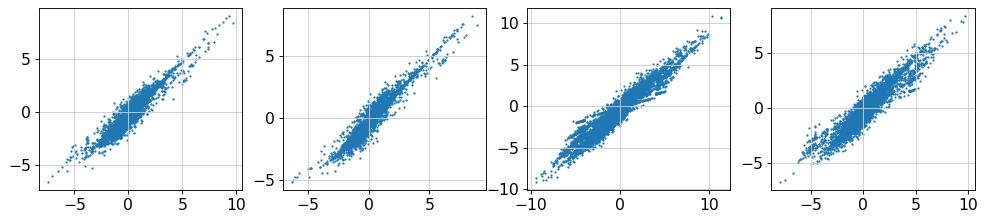

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
for ax in ax:
    stim = np.random.choice(stims)
    hour = np.random.choice(hours)
    genes = de[stim][hour]['log2FoldChange'].index
    x = de[stim][hour]['log2FoldChange'].values
    y = df.loc[(df.index.get_level_values('STIM') == stim) & (df.index.get_level_values('TIME') == hour),genes].mean(0).values
    ax.scatter(x, y, s=1);

Okay, they correlate, but I'm not sure why they aren't exactly the same. Perhaps DESeq2 does some more complex corrections when calculating. I think I'll take the ones I have at face value though.

## DE Genes: 2-sided, Static Cutoffs

Using a static cutoff for LFC and strict p_adj < 0.01, I will now extract out differentially expressed genes. At Hyun's suggestion, using only the top _n_ significant genes from each comparison, since some conditions like PMAI and R848 have 1000s, while TNF-alpha conditions have in the 10s or 100. Using the top 200 from each condition will not bias the heatmap towards the most stimulating conditions.

In [61]:
de_genes = dict() # make a dictionary

for stim in stims:
    de_genes[stim] = dict() # each value will be each stim, itself be a dictionary with values of hours

# for each stim, each non-zero hour...
combos = list(it.product(stims, hours))
num_top_genes_to_keep = 200
for combo in combos: 
    stim = combo[0]
    hour = combo[1]
    df = de[stim][hour] # get the DE results
    df = df[(df['log2FoldChange'] > 2) | (df['log2FoldChange'] < -2)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.01)]
    de_genes[stim][hour] = df.sort_values('padj').index[:num_top_genes_to_keep]
    

In [62]:
all_de_genes = list()
for stim in stims:
    for hour in hours:
        de_genes_list = de_genes[stim][hour]
        print((stim, hour, len(de_genes_list)))
        all_de_genes.append(de_genes[stim][hour])

('IFNG', '3', 200)
('IFNG', '6', 200)
('IFNG', '9', 200)
('IFNG', '12', 200)
('IFNB', '3', 200)
('IFNB', '6', 200)
('IFNB', '9', 200)
('IFNB', '12', 200)
('PMAI', '3', 200)
('PMAI', '6', 200)
('PMAI', '9', 200)
('PMAI', '12', 200)
('R848', '3', 200)
('R848', '6', 200)
('R848', '9', 200)
('R848', '12', 200)
('TNFa', '3', 14)
('TNFa', '6', 57)
('TNFa', '9', 58)
('TNFa', '12', 200)


In [63]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

Turn the counts matrix into an adata object for easy processing like normalize, log1p, and scaling.

In [64]:
counts_for_heatmap = counts['raw'].sort_values(by=['STIM', 'TIME']).copy() # this fucked me over, be careful
obs = pd.DataFrame(index=['-'.join(i) for i in counts_for_heatmap.index.values])
var = pd.DataFrame(index=counts['raw'].columns)

In [65]:
adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [66]:
adata

AnnData object with n_obs × n_vars = 75 × 33538

In [67]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [68]:
adata.raw = adata.copy()

In [69]:
sc.pp.log1p(adata)

In [70]:
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [71]:
df_de = pd.DataFrame(adata[:,all_de_genes].X, index=obs.index, columns=all_de_genes)

In [72]:
df_de.shape

(75, 1229)

## Plotting

I want to show in the following order, based on what I've observed over the course of my data analysis, this is in quasi-order of strength of signal.

In [73]:
ordering_dict = {'None':0,
                 'Control': 1,
                 'TNFa': 2,
                 'IFNG': 3,
                 'IFNB': 4,
                 'R848': 5,
                 'PMAI':6
                }

### Heirarchical Clustering

When I originally created this notebook, I wanted to use heirarchical clustering to find gene modules by just cutting the tree at a certain point. While this yielded some biologically relevant modules, it required me to ask the `cut_tree()` function to find _many_ more clusters than were actually relevant or contained a sufficient number of genes, as shown below:

In [76]:
df_de_ordered = df_de.loc[['-'.join(i) for i in sorted(df_de.index.str.split('-').values, key=lambda x: (ordering_dict[x[2]], int(x[1]), x[0]))],:]

In [64]:
# plt.figure(figsize=(20,15))
# sns.clustermap(df_de, figsize=(20,15));

In [65]:
# sns.clustermap(df_de_ordered, figsize=(20,10), row_cluster=False, standard_scale=1);

In [66]:
# linkage_df = df_de_ordered.T.copy()

# linkage_df = linkage_df.subtract(linkage_df.min(1), axis=0)
# linkage_df = linkage_df.divide(linkage_df.max(1), axis=0)

Better to separately make the linkage matrix, becuase I'm going to want to cluster the genes based on it.

In [67]:
Z = scipy.cluster.hierarchy.linkage(df_de_ordered.T, method='average', optimal_ordering=True)

Gotta love scanpy's colors:

In [68]:
num_modules = 100
color_dict = dict(zip(range(num_modules),sc.pl.palettes.default_102))

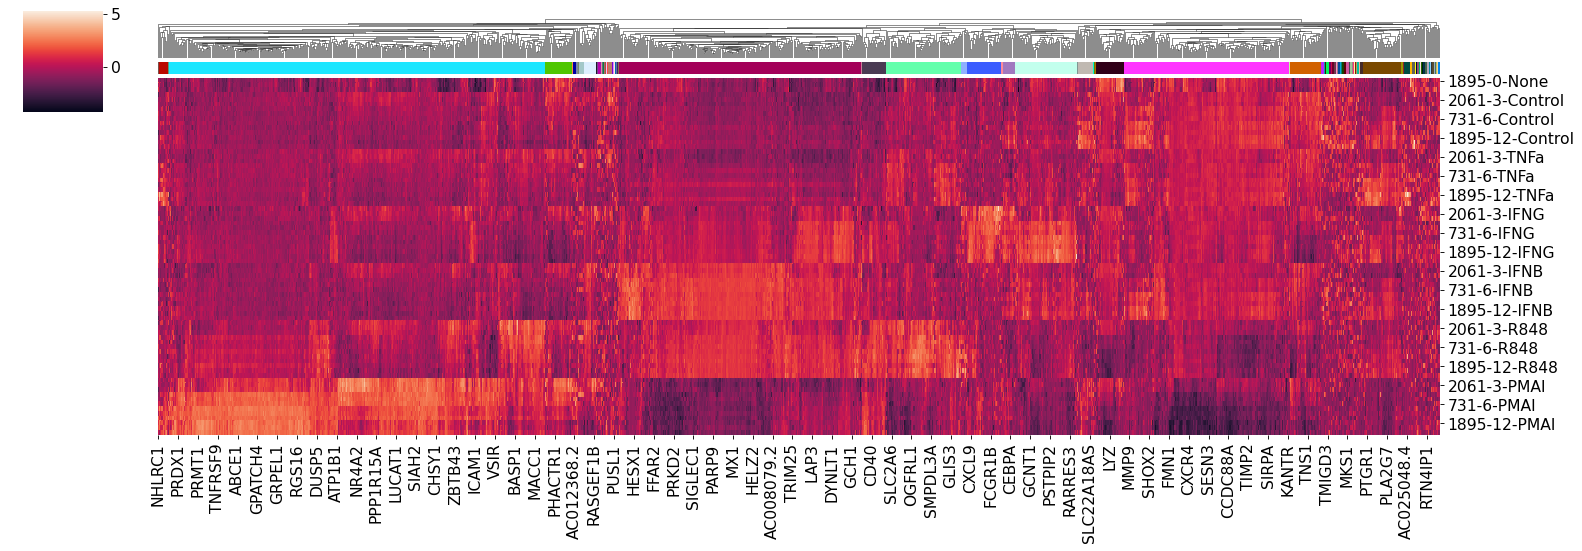

In [69]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()
sns.clustermap(df_de_ordered, figsize=(20,7), 
               row_cluster=False,
               col_linkage=Z, 
               col_colors=list(map(lambda x: color_dict[x], modules)),
               dendrogram_ratio=0.1,
              );

Extract out gene names from the modules and get better coloring.

In [70]:
# credit to user Has QUIT--Anony-Mousse from https://stackoverflow.com/questions/12572436/calculate-ordering-of-dendrogram-leaves
n = len(Z) + 1
cache = dict()
for k in range(len(Z)):
    c1, c2 = int(Z[k][0]), int(Z[k][1])
    c1 = [c1] if c1 < n else cache.pop(c1)
    c2 = [c2] if c2 < n else cache.pop(c2)
    cache[n+k] = c1 + c2
ordering = cache[2*len(Z)]

In [71]:
# cmap = mpl.cm.get_cmap('prism')

In [72]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()[ordering]

In [73]:
module_vals, module_counts = np.unique(modules, return_counts=True)

In [74]:
modules_size_ordered = pd.DataFrame(data=zip(module_vals, module_counts),
                                    columns=['v','c']).sort_values('c', ascending=False)['v'].values

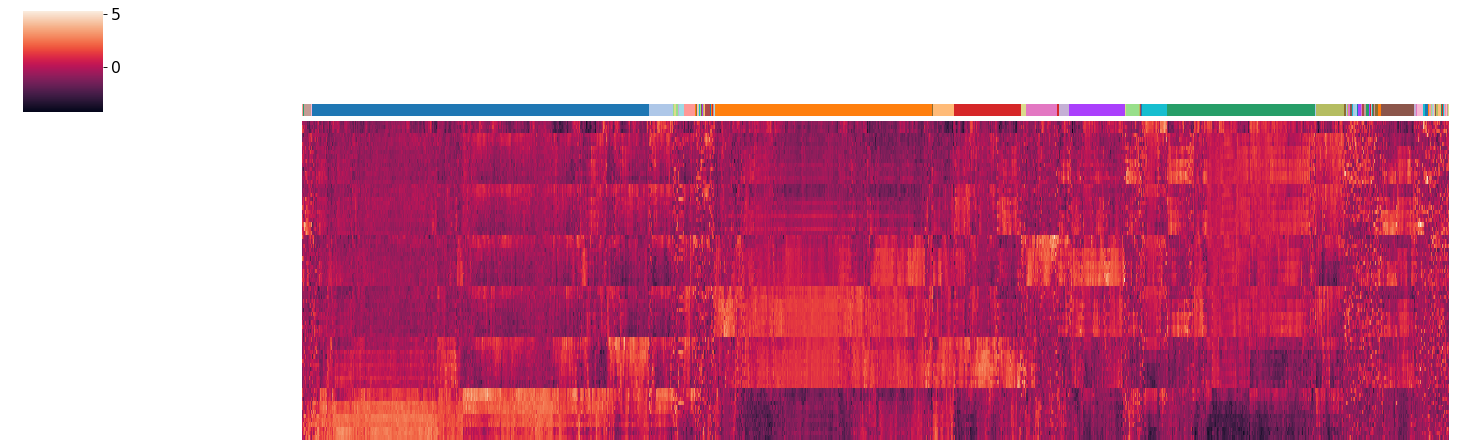

In [75]:
color_dict = dict(zip(modules_size_ordered,sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))))
genes = df_de_ordered.columns.values[ordering]
cg = sns.clustermap(df_de_ordered[genes], figsize=(20,7), 
                    row_cluster=False,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

#### Module Identification

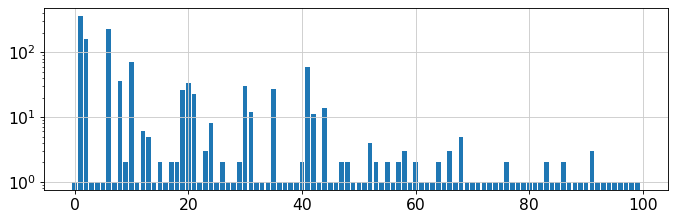

In [76]:
plt.figure(figsize=(10,3))
plt.bar(module_vals, module_counts);#, s=5);
plt.yscale('log');

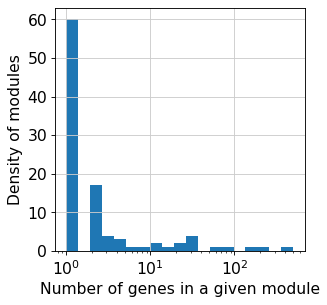

In [77]:
plt.hist(module_counts, bins=np.logspace(np.log10(1), np.log10(500), 20));
plt.xscale('log')
plt.xlabel('Number of genes in a given module')
plt.ylabel('Density of modules');

Only want to keep the main modules:

In [78]:
main_modules = np.arange(num_modules)[module_counts > 5]
main_modules_genes = dict()
for module in main_modules:
    main_modules_genes[module] = genes[modules == module]

In [79]:
len(main_modules_genes)

16

Visualize the colors for the modules.

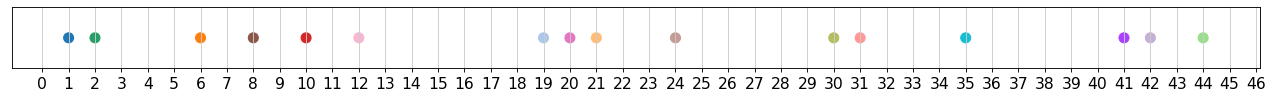

In [80]:
plt.figure(figsize=(20,1))
plt.scatter(list(main_modules), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.xticks(range(max(main_modules) + 3))
plt.yticks([]);

### KMeans Clustering

When I started playing with making the equivalent heatmap for the single-cell data, I realized that KMeans actually works really well, and the clusters are all well-sized (i.e. no clusters with a single gene). So I decided to do that here:

In [74]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Code for finding optimal k taken from [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [77]:
df_de_ordered.shape

(75, 1229)

distortions = list()
K = np.concatenate(([1],np.arange(10,210,10)))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(df_de_ordered.T)
    kmeanModel.fit(df_de.T)
    distortions.append(sum(np.min(cdist(df_de_ordered.T, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_de_ordered.T.shape[0])

In [ ]:
rise = [distortions[i] - distortions[i - 1] for i in range(1, len(K))]
run = [K[i] - K[i - 1] for i in range(1, len(K))]
slopes = np.array([-i/j for i, j in zip(rise, run)])

In [ ]:
# Plot the elbow
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(K, distortions - min(distortions) + 1, 'bx-')
ax[0].set_ylabel('Distortion')
ax[0].set_yscale('log')
ax[1].bar(K[1:], slopes, width=4, color='k', alpha=0.5)
ax[1].set_ylabel('Slopes');

In [84]:
n_clusts = 30
kmeans = KMeans(n_clusters=n_clusts).fit(df_de.T)

In [ ]:
# with open(prefix + 'kmeans.modules/kmeans.n30.out.pkl', 'wb') as file:
#     pkl.dump(kmeans, file)

In [79]:
with open(prefix + 'kmeans.modules/kmeans.n30.out.pkl', 'rb') as file:
    kmeans = pkl.load(file)

Gotta love scanpy's colors:

In [85]:
color_dict = dict(zip(range(n_clusts),sc.pl.palettes.default_20*2))

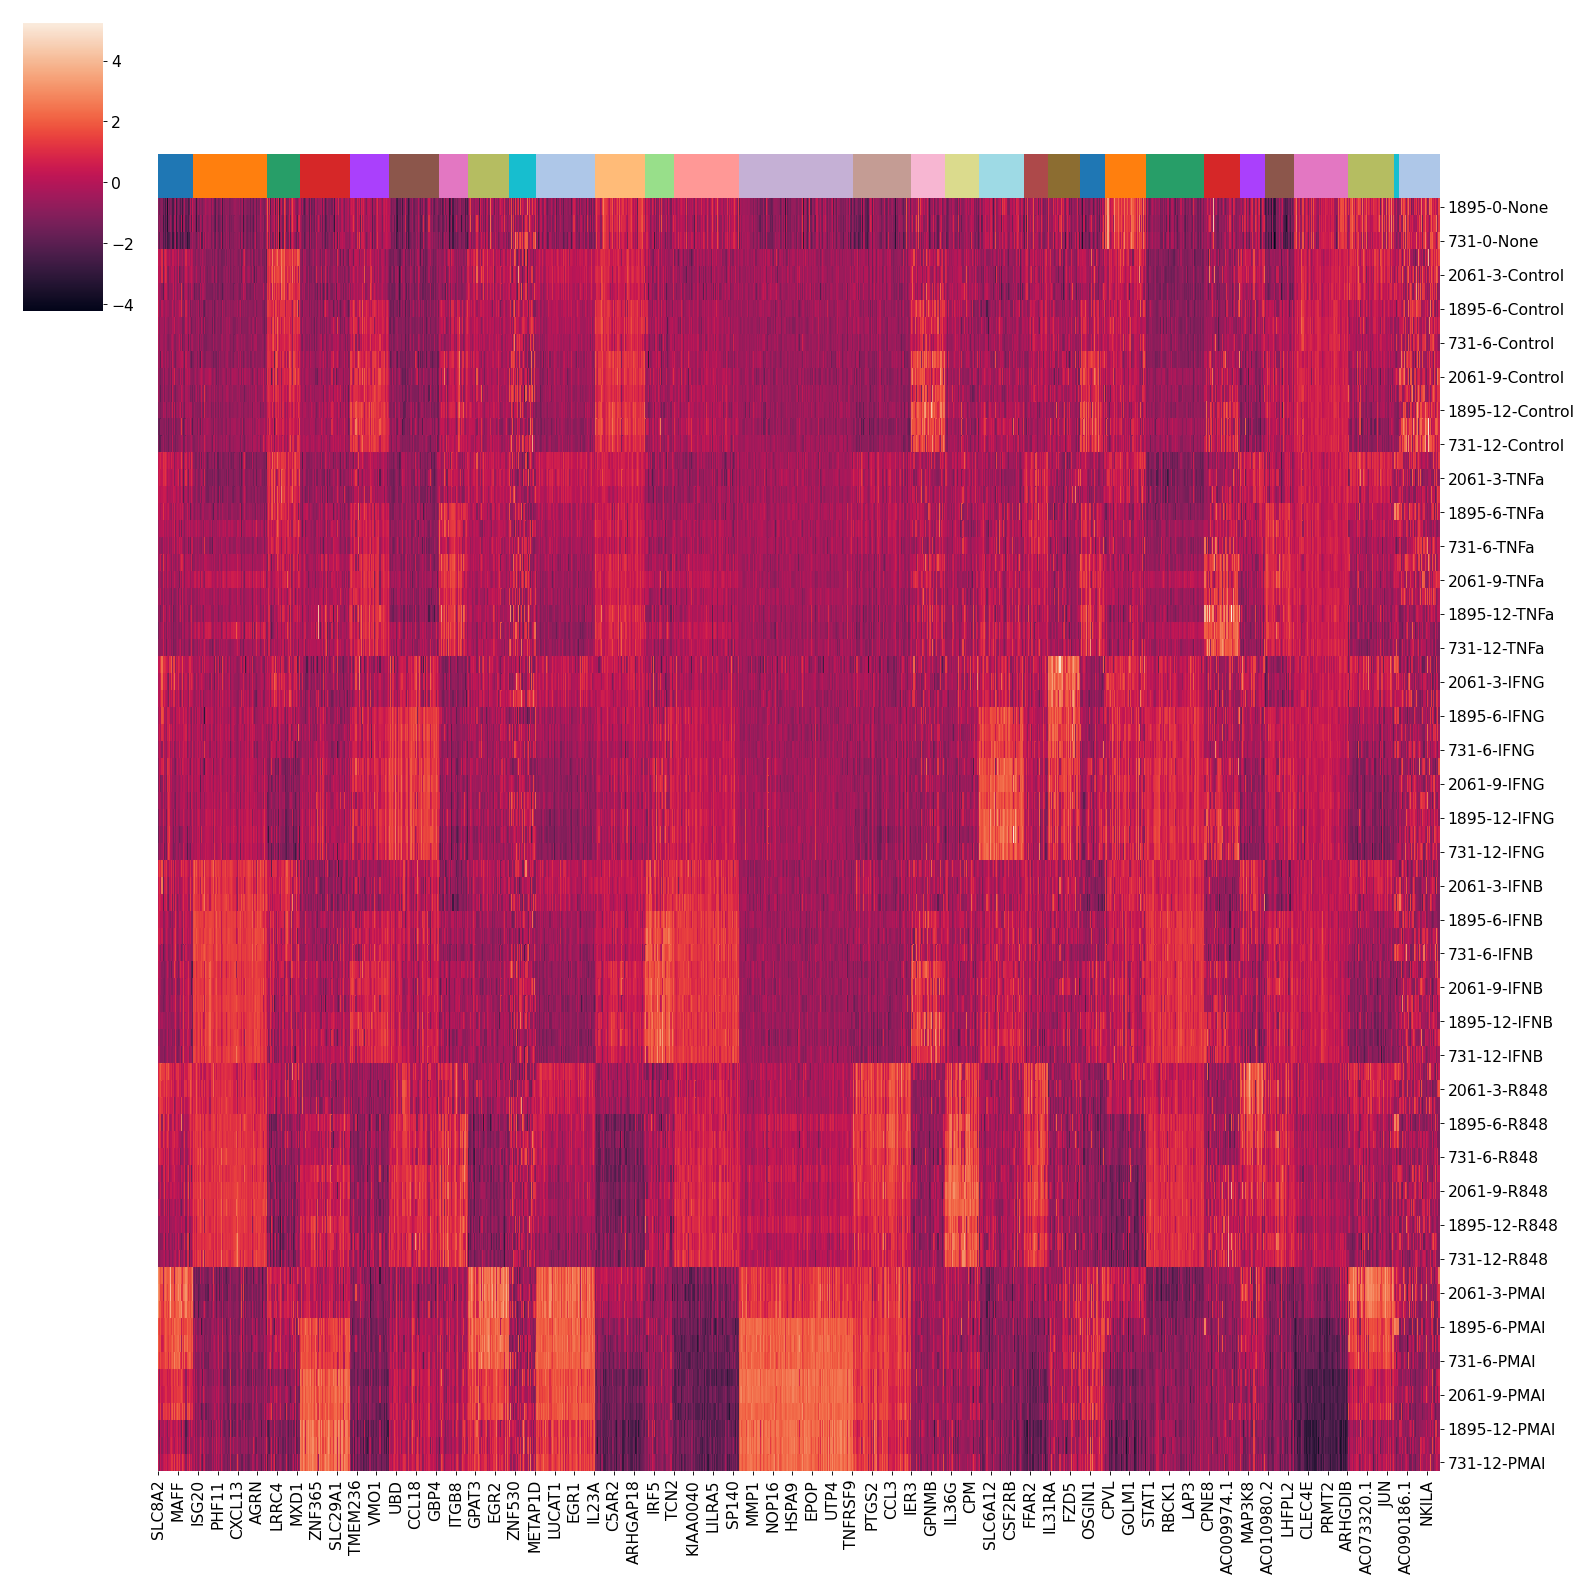

In [86]:
cg = sns.clustermap(df_de_ordered.iloc[:,np.argsort(kmeans.labels_)], figsize=(20,20), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    dendrogram_ratio=0.1,
                   );
# plt.tight_layout()

In [87]:
ordered_conds = [i.split('-')[2] for i in df_de_ordered.index]
ordered_times = [i.split('-')[1] for i in df_de_ordered.index] # convert to int to get good order

In [88]:
times = np.unique([int(i) for i in ordered_times])

In [89]:
cmap = mpl.cm.get_cmap('gray', len(times) + 2)
time_colors = dict(zip([str(i) for i in times], # convert back to a string
                       [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(1,cmap.N - 1)[::-1]]))

In [90]:
with open(prefix + '../production.run/cond.colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

In [91]:
cond_dict = {'TNFa': 'A',
             'R848': 'R',
             'PMAI': 'P',
             'IFNG': 'G',
             'IFNB': 'B',
             'Control': 'C'
            }

In [92]:
cond_colors['N'] = cond_colors['0']
cond_dict['None'] = 'N'

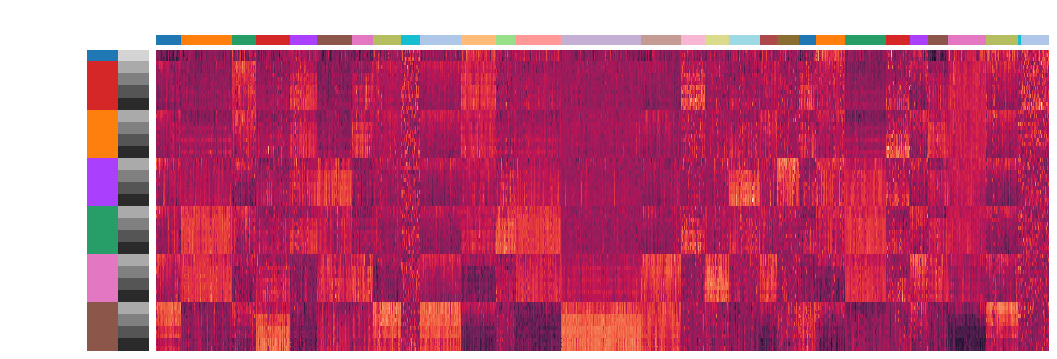

In [93]:
cg = sns.clustermap(df_de_ordered.iloc[:,np.argsort(kmeans.labels_)], figsize=(15,6), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    row_colors=[list(map(lambda x: cond_colors[cond_dict[x]], ordered_conds)),
                                list(map(lambda x: time_colors[x], ordered_times))],
                    dendrogram_ratio=0.07,
                    cbar_pos=None);
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

In [94]:
main_modules = np.arange(n_clusts)
main_modules_genes = dict(zip(main_modules, [df_de.columns[kmeans.labels_ == i].values for i in range(n_clusts)]))

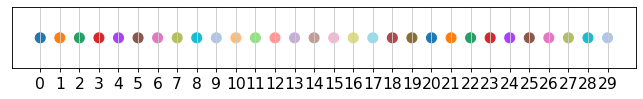

In [95]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

In [96]:
# with open(prefix + 'kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'wb') as file:
#     pkl.dump(main_modules_genes, file)

In [97]:
with open(prefix + 'kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'rb') as file:
    main_modules_genes = pkl.load(file)

### Gene Ontology

Run gene ontology analyses on the modules:

In [98]:
obo_fname = download_go_basic_obo(prefix + "go-basic.obo")
fin_gene2go = download_ncbi_associations(prefix + 'gene2go')

  EXISTS: /data/codec/bulk.jan20/go-basic.obo
  EXISTS: /data/codec/bulk.jan20/gene2go


In [99]:
obodag = GODag(prefix + "go-basic.obo")

/data/codec/bulk.jan20/go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms


In [100]:
# Read NCBI's gene2go. Store annotations in a list of named tuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:04.207588 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: /data/codec/bulk.jan20/gene2go 
BP 17,541 annotated human genes
MF 17,384 annotated human genes
CC 18,648 annotated human genes


In [101]:
gene_ids = list(GeneID2nt_hum.keys())
symbol2geneid = dict(zip([GeneID2nt_hum[i].Symbol for i in gene_ids], [i for i in gene_ids]))

Next cell produces a lot of output, recommend collapsing it in notebook.

In [102]:
results = list()
percent_genes_in_annot = list()
for module in tqdm(main_modules_genes):
    ids = list()

    for i in main_modules_genes[module]:
        try:
            ids.append(symbol2geneid[i])
        except:
            continue
    percent_genes_in_annot.append(len(ids)/len(main_modules_genes[module]))
    
    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method
    
    goea_results_all = goeaobj.run_study(ids)
    for i in goea_results_all:
        results.append([str(module), i.name, i.NS, -np.log10(i.p_fdr_bh)])


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association

Run BP Gene Ontology Analysis: current study set of 31 IDs ... 94%     29 of     31 study items found in association
100%     31 of     31 study items found in population(20913)
Calculating 12,176 uncorrected p-values using fisher_scipy_stats
  12,176 GO terms are associated with 16,711 of 20,913 population items
     207 GO terms are associated with     29 of     31 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_b

In [123]:
results_df = pd.DataFrame(results, columns=['Module', 'GO_term', 'GO_type', '-log10padj'])

In [124]:
results_df['Module'] = results_df['Module'].astype(np.int)

In [247]:
# with open(prefix + 'kmeans.modules/kmeans.n30.results_df.pkl', 'wb') as file:
#     pkl.dump(results_df, file)

In [98]:
with open(prefix + 'kmeans.modules/kmeans.n30.results_df.pkl', 'rb') as file:
    results_df = pkl.load(file)

Visualize the significance levels for the terms found in enriched in each module. BP = biological process, MF = molecular function, CC = cellular component.

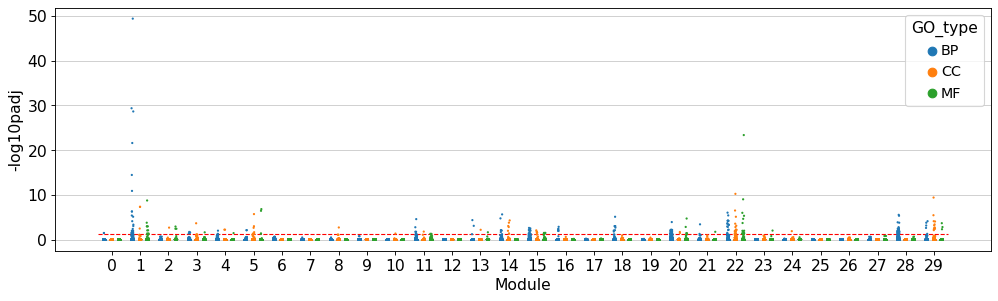

In [99]:
plt.figure(figsize=(15,4))
sns.stripplot(data=results_df,x='Module', hue='GO_type', y='-log10padj', dodge=True, size=2);
plt.plot([-0.5,len(main_modules) - 0.5],[-np.log10(0.05)]*2, linestyle='--', linewidth=1, color='r');

Is the lack of significance from some modules due to the fact that the gene names from that module did not exactly match gene names in the gene ontology dictionary?

In [ ]:
plt.figure(figsize=(12,4))
plt.bar([str(i) for i in main_modules], percent_genes_in_annot);

I think at least 60% of genes is okay.

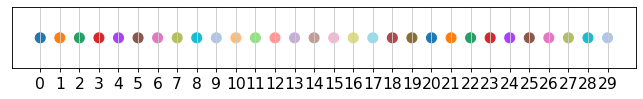

In [101]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

### Print out and Explore GO Analysis Results

In [102]:
from IPython.display import display # need this to print out the results without truncation.

In [103]:
sig_dfs = dict()
for module in main_modules:
    df = results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                (results_df['Module'] == module)
               ][['GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False)
    sig_dfs[module] = df.copy()

In [130]:
for module in sig_dfs:
    print((module, len(sig_dfs[module])))

(0, 2)
(1, 41)
(2, 4)
(3, 7)
(4, 5)
(5, 14)
(6, 0)
(7, 0)
(8, 1)
(9, 0)
(10, 1)
(11, 9)
(12, 0)
(13, 4)
(14, 13)
(15, 21)
(16, 6)
(17, 0)
(18, 8)
(19, 0)
(20, 41)
(21, 2)
(22, 47)
(23, 1)
(24, 1)
(25, 0)
(26, 0)
(27, 0)
(28, 38)
(29, 19)


In [105]:
sig_modules = [1, 2, 3, 4, 5, 11, 14, 15, 16, 18, 20, 22, 28, 29]

In [106]:
len(sig_modules)

14

In [148]:
module = 25
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'MF')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'CC')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False).head(5))

,Module,GO_term,GO_type,-log10padj
465532,25,arachidonate 8(S)-lipoxygenase activity,MF,-0.0
468325,25,"rRNA (adenine-N6,N6-)-dimethyltransferase activity",MF,-0.0
468295,25,long-chain-alcohol oxidase activity,MF,-0.0
468296,25,enzyme binding,MF,-0.0
468297,25,histone acetyltransferase activity (H4-K16 specific),MF,-0.0


,Module,GO_term,GO_type,-log10padj
463801,25,collagen type VI trimer,CC,-0.0
464951,25,ATF4-CREB1 transcription factor complex,CC,-0.0
464962,25,smooth endoplasmic reticulum,CC,-0.0
464961,25,nuclear pericentric heterochromatin,CC,-0.0
464960,25,nuclear exosome (RNase complex),CC,-0.0


,Module,GO_term,GO_type,-log10padj
451625,25,cellular response to menadione,BP,-0.0
459746,25,positive regulation of skeletal muscle fiber development,BP,-0.0
459737,25,aortic valve morphogenesis,BP,-0.0
459738,25,feeding behavior,BP,-0.0
459739,25,negative regulation of steroid biosynthetic process,BP,-0.0


In [149]:
for module in sig_modules:
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        print(module)
        
#         display(sig_dfs[module][:10])
        
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'MF'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'CC'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'][:5])

1


,GO_type,GO_term,-log10padj
31972,MF,double-stranded RNA binding,8.759528
31973,MF,2'-5'-oligoadenylate synthetase activity,3.795217
31974,MF,protein binding,2.981252
31975,MF,single-stranded RNA binding,2.981252
31976,MF,RNA binding,2.981252


,GO_type,GO_term,-log10padj
30241,CC,cytoplasm,7.340870
30242,CC,cytosol,7.340870
30243,CC,nucleus,2.498341


,GO_type,GO_term,-log10padj
18065,BP,defense response to virus,49.350886
18066,BP,response to virus,29.348444
18067,BP,type I interferon signaling pathway,28.632232
18068,BP,negative regulation of viral genome replication,21.588635
18069,BP,innate immune response,14.457008


2


,GO_type,GO_term,-log10padj
50037,MF,"DNA-binding transcription factor activity, RNA polymerase II-specific",2.944044
50038,MF,glucocorticoid receptor binding,2.449056
50039,MF,N-box binding,2.449056


,GO_type,GO_term,-log10padj
48306,CC,nuclear chromatin,2.7017


,GO_type,GO_term,-log10padj


3


,GO_type,GO_term,-log10padj
68102,MF,complement component C5a receptor activity,1.65049


,GO_type,GO_term,-log10padj
66371,CC,plasma membrane,3.674337


,GO_type,GO_term,-log10padj
54195,BP,neutrophil degranulation,1.741061
54196,BP,complement component C5a signaling pathway,1.597115
54197,BP,positive regulation of ERK1 and ERK2 cascade,1.597115
54198,BP,phagocytosis,1.597115
54199,BP,negative regulation of metallopeptidase activity,1.406370


4


,GO_type,GO_term,-log10padj
86167,MF,chemokine activity,1.476293


,GO_type,GO_term,-log10padj
84436,CC,extracellular region,2.244004
84437,CC,extracellular space,2.244004


,GO_type,GO_term,-log10padj
72260,BP,leukocyte chemotaxis,2.021166
72261,BP,cellular response to lipopolysaccharide,1.322247


5


,GO_type,GO_term,-log10padj
104232,MF,RNA binding,6.832952
104233,MF,protein binding,6.455447
104234,MF,snoRNA binding,1.377837
104235,MF,translation initiation factor activity,1.359956


,GO_type,GO_term,-log10padj
102501,CC,nucleolus,5.723267
102502,CC,box C/D snoRNP complex,3.017337
102503,CC,membrane,2.663351
102504,CC,cytoplasm,1.687171
102505,CC,fibrillar center,1.341039


,GO_type,GO_term,-log10padj
90325,BP,rRNA processing,2.131635
90326,BP,cytokine-mediated signaling pathway,2.131635


11


,GO_type,GO_term,-log10padj
212622,MF,"DNA-binding transcription activator activity, RNA polymerase II-specific",1.324642
212623,MF,protein heterodimerization activity,1.307801


,GO_type,GO_term,-log10padj
210891,CC,transcription factor AP-1 complex,1.812115


,GO_type,GO_term,-log10padj
198715,BP,response to cAMP,4.597448
198716,BP,cellular response to hormone stimulus,2.784038
198717,BP,positive regulation of transcription by RNA polymerase II,1.778232
198718,BP,regulation of DNA-binding transcription factor activity,1.778232
198719,BP,cellular response to corticotropin-releasing hormone stimulus,1.442361


14


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
265086,CC,plasma membrane,4.311191
265087,CC,cell,3.803663
265088,CC,extracellular space,3.072537
265089,CC,tertiary granule membrane,2.830405
265090,CC,external side of plasma membrane,1.997753


,GO_type,GO_term,-log10padj
252910,BP,immune response,5.654642
252911,BP,neutrophil degranulation,4.765432
252912,BP,inflammatory response,2.119782
252913,BP,chemotaxis,2.119782
252914,BP,positive regulation of angiogenesis,2.038574


15


,GO_type,GO_term,-log10padj
284882,MF,ATPase-coupled peptide transmembrane transporter activity,1.530475
284883,MF,ATPase-coupled peptide antigen transmembrane transporter activity,1.530475
284884,MF,TAP1 binding,1.406756
284885,MF,kinase inhibitor activity,1.406756
284886,MF,CXCR3 chemokine receptor binding,1.406756


,GO_type,GO_term,-log10padj
283151,CC,TAP complex,2.086544
283152,CC,cytoplasmic vesicle,1.806449
283153,CC,spermatoproteasome complex,1.611861
283154,CC,symbiont-containing vacuole membrane,1.611861
283155,CC,MHC class I peptide loading complex,1.611861


,GO_type,GO_term,-log10padj
270975,BP,tumor necrosis factor-mediated signaling pathway,2.636199
270976,BP,"antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent",2.533520
270977,BP,interleukin-27-mediated signaling pathway,2.181258
270978,BP,cellular response to interferon-gamma,2.180693
270979,BP,regulation of interferon-gamma-mediated signaling pathway,2.165564


16


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
289040,BP,cellular response to cadmium ion,2.882735
289041,BP,detoxification of copper ion,2.426428
289042,BP,negative regulation of growth,2.332187
289043,BP,cellular response to zinc ion,2.103906
289044,BP,cellular response to copper ion,1.974796


18


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
325170,BP,defense response to virus,5.124661
325171,BP,toll-like receptor 9 signaling pathway,3.039414
325172,BP,negative regulation of viral genome replication,3.039414
325173,BP,toll-like receptor 7 signaling pathway,3.021206
325174,BP,response to interferon-gamma,2.703009


20


,GO_type,GO_term,-log10padj
375207,MF,cytokine activity,4.732406
375208,MF,tumor necrosis factor receptor binding,2.853638
375209,MF,identical protein binding,1.485980
375210,MF,CCR chemokine receptor binding,1.411345
375211,MF,CCR1 chemokine receptor binding,1.387912


,GO_type,GO_term,-log10padj
373476,CC,extracellular space,1.729856
373477,CC,external side of plasma membrane,1.486180


,GO_type,GO_term,-log10padj
361300,BP,cytokine-mediated signaling pathway,3.942704
361301,BP,cellular response to interleukin-1,2.199087
361302,BP,positive regulation of nitric oxide biosynthetic process,2.174694
361303,BP,apoptotic process,2.174694
361304,BP,positive regulation of membrane protein ectodomain proteolysis,2.174694


22


,GO_type,GO_term,-log10padj
411337,MF,RNA binding,23.360767
411338,MF,unfolded protein binding,9.023433
411339,MF,ATP binding,6.002298
411340,MF,protein binding,5.340880
411341,MF,protein folding chaperone,4.664671


,GO_type,GO_term,-log10padj
409606,CC,nucleolus,10.241232
409607,CC,membrane,6.519920
409608,CC,"preribosome, large subunit precursor",5.124596
409609,CC,extracellular exosome,3.582000
409610,CC,cytoplasm,3.125474


,GO_type,GO_term,-log10padj
397430,BP,rRNA processing,6.040821
397431,BP,ribosomal large subunit biogenesis,5.427427
397432,BP,protein stabilization,4.238683
397433,BP,positive regulation of protein localization to Cajal body,4.238683
397434,BP,response to unfolded protein,4.227316


28


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
505820,BP,inflammatory response,5.556012
505821,BP,cytokine-mediated signaling pathway,5.345955
505822,BP,positive regulation of vascular endothelial growth factor production,3.888010
505823,BP,positive regulation of neuroinflammatory response,3.795166
505824,BP,positive regulation of smooth muscle cell proliferation,2.803916


29


,GO_type,GO_term,-log10padj
537792,MF,peptide antigen binding,3.691320
537793,MF,MHC class II receptor activity,2.829028
537794,MF,MHC class II protein complex binding,2.339478


,GO_type,GO_term,-log10padj
536061,CC,MHC class II protein complex,9.415346
536062,CC,clathrin-coated endocytic vesicle membrane,5.466313
536063,CC,integral component of lumenal side of endoplasmic reticulum membrane,4.135141
536064,CC,plasma membrane,4.067765
536065,CC,transport vesicle membrane,3.420023


,GO_type,GO_term,-log10padj
523885,BP,peptide antigen assembly with MHC class II protein complex,4.136632
523886,BP,antigen processing and presentation of exogenous peptide antigen via MHC class II,3.798667
523887,BP,interferon-gamma-mediated signaling pathway,3.173135
523888,BP,adaptive immune response,2.633257
523889,BP,immune response,1.313907


In [160]:
for module in sig_modules:
    df = sig_dfs[module][sig_dfs[module]['GO_term'].str.contains('lipopolysaccharide')]
    if len(df) != 0:
        print(module)
        print(df)
        print('')

4
      GO_type                                  GO_term  -log10padj
72261      BP  cellular response to lipopolysaccharide    1.322247

11
       GO_type                         GO_term  -log10padj
198720      BP  response to lipopolysaccharide    1.320502

28
       GO_type                                        GO_term  -log10padj
505825      BP        cellular response to lipopolysaccharide    2.589933
505831      BP  lipopolysaccharide-mediated signaling pathway    2.048618



To export to csv to open in Excel for easy labeling:

In [151]:
dfs = list()
for sig_module in sig_modules:
    dfs.append(results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                          (results_df['Module'] == sig_module)
                         ][['Module', 'GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False))

In [242]:
# pd.concat(dfs).to_csv(prefix + 'kmeans.modules/kmeans.n30.sig.modules.GO.csv')

### Label the Significant Modules

In [107]:
sig_modules

[1, 2, 3, 4, 5, 11, 14, 15, 16, 18, 20, 22, 28, 29]

In [108]:
sig_module_labels = {
    1: 'viral response & interferon activity',
    2: 'glucocorticoid stress response',
    3: 'complement cascade',
    4: 'chemotaxis',
    5: 'protein production',
    11: 'cAMP response',
    14: 'degranulation',
    15: 'peptide transporter & interferon activity',
    16: 'metal ion response',
    18: 'TLR signaling',
    20: 'cytokine activity',
    22: 'protein production',
    28: 'Inflammation & T helper activity', 
    29: 'MHC II activity',
}

In [109]:
len(sig_modules)

14

In [110]:
cond_long_colors = dict(zip([k for k, v in cond_dict.items()], [cond_colors[v] for k, v in cond_dict.items()]))

I realized that plotting mean expression of the genes in each module may reduce the signal for genes that are part of a module (and contribute to the module's signifance) but that are downregulated. Therefore, going to plot the mean log fold change (from control) of genes within the module, and just won't plot control (since it will be 1).

In [ ]:
# specific_counts = specific_counts.abs()
# specific_counts = specific_counts.reset_index()

# specific_counts['TIME'] = specific_counts['TIME'].astype(int)

# specific_counts.mean(axis=0,level=['TIME', 'STIM']).head()

# specific_counts.sort_values(['STIM','TIME','IND'])

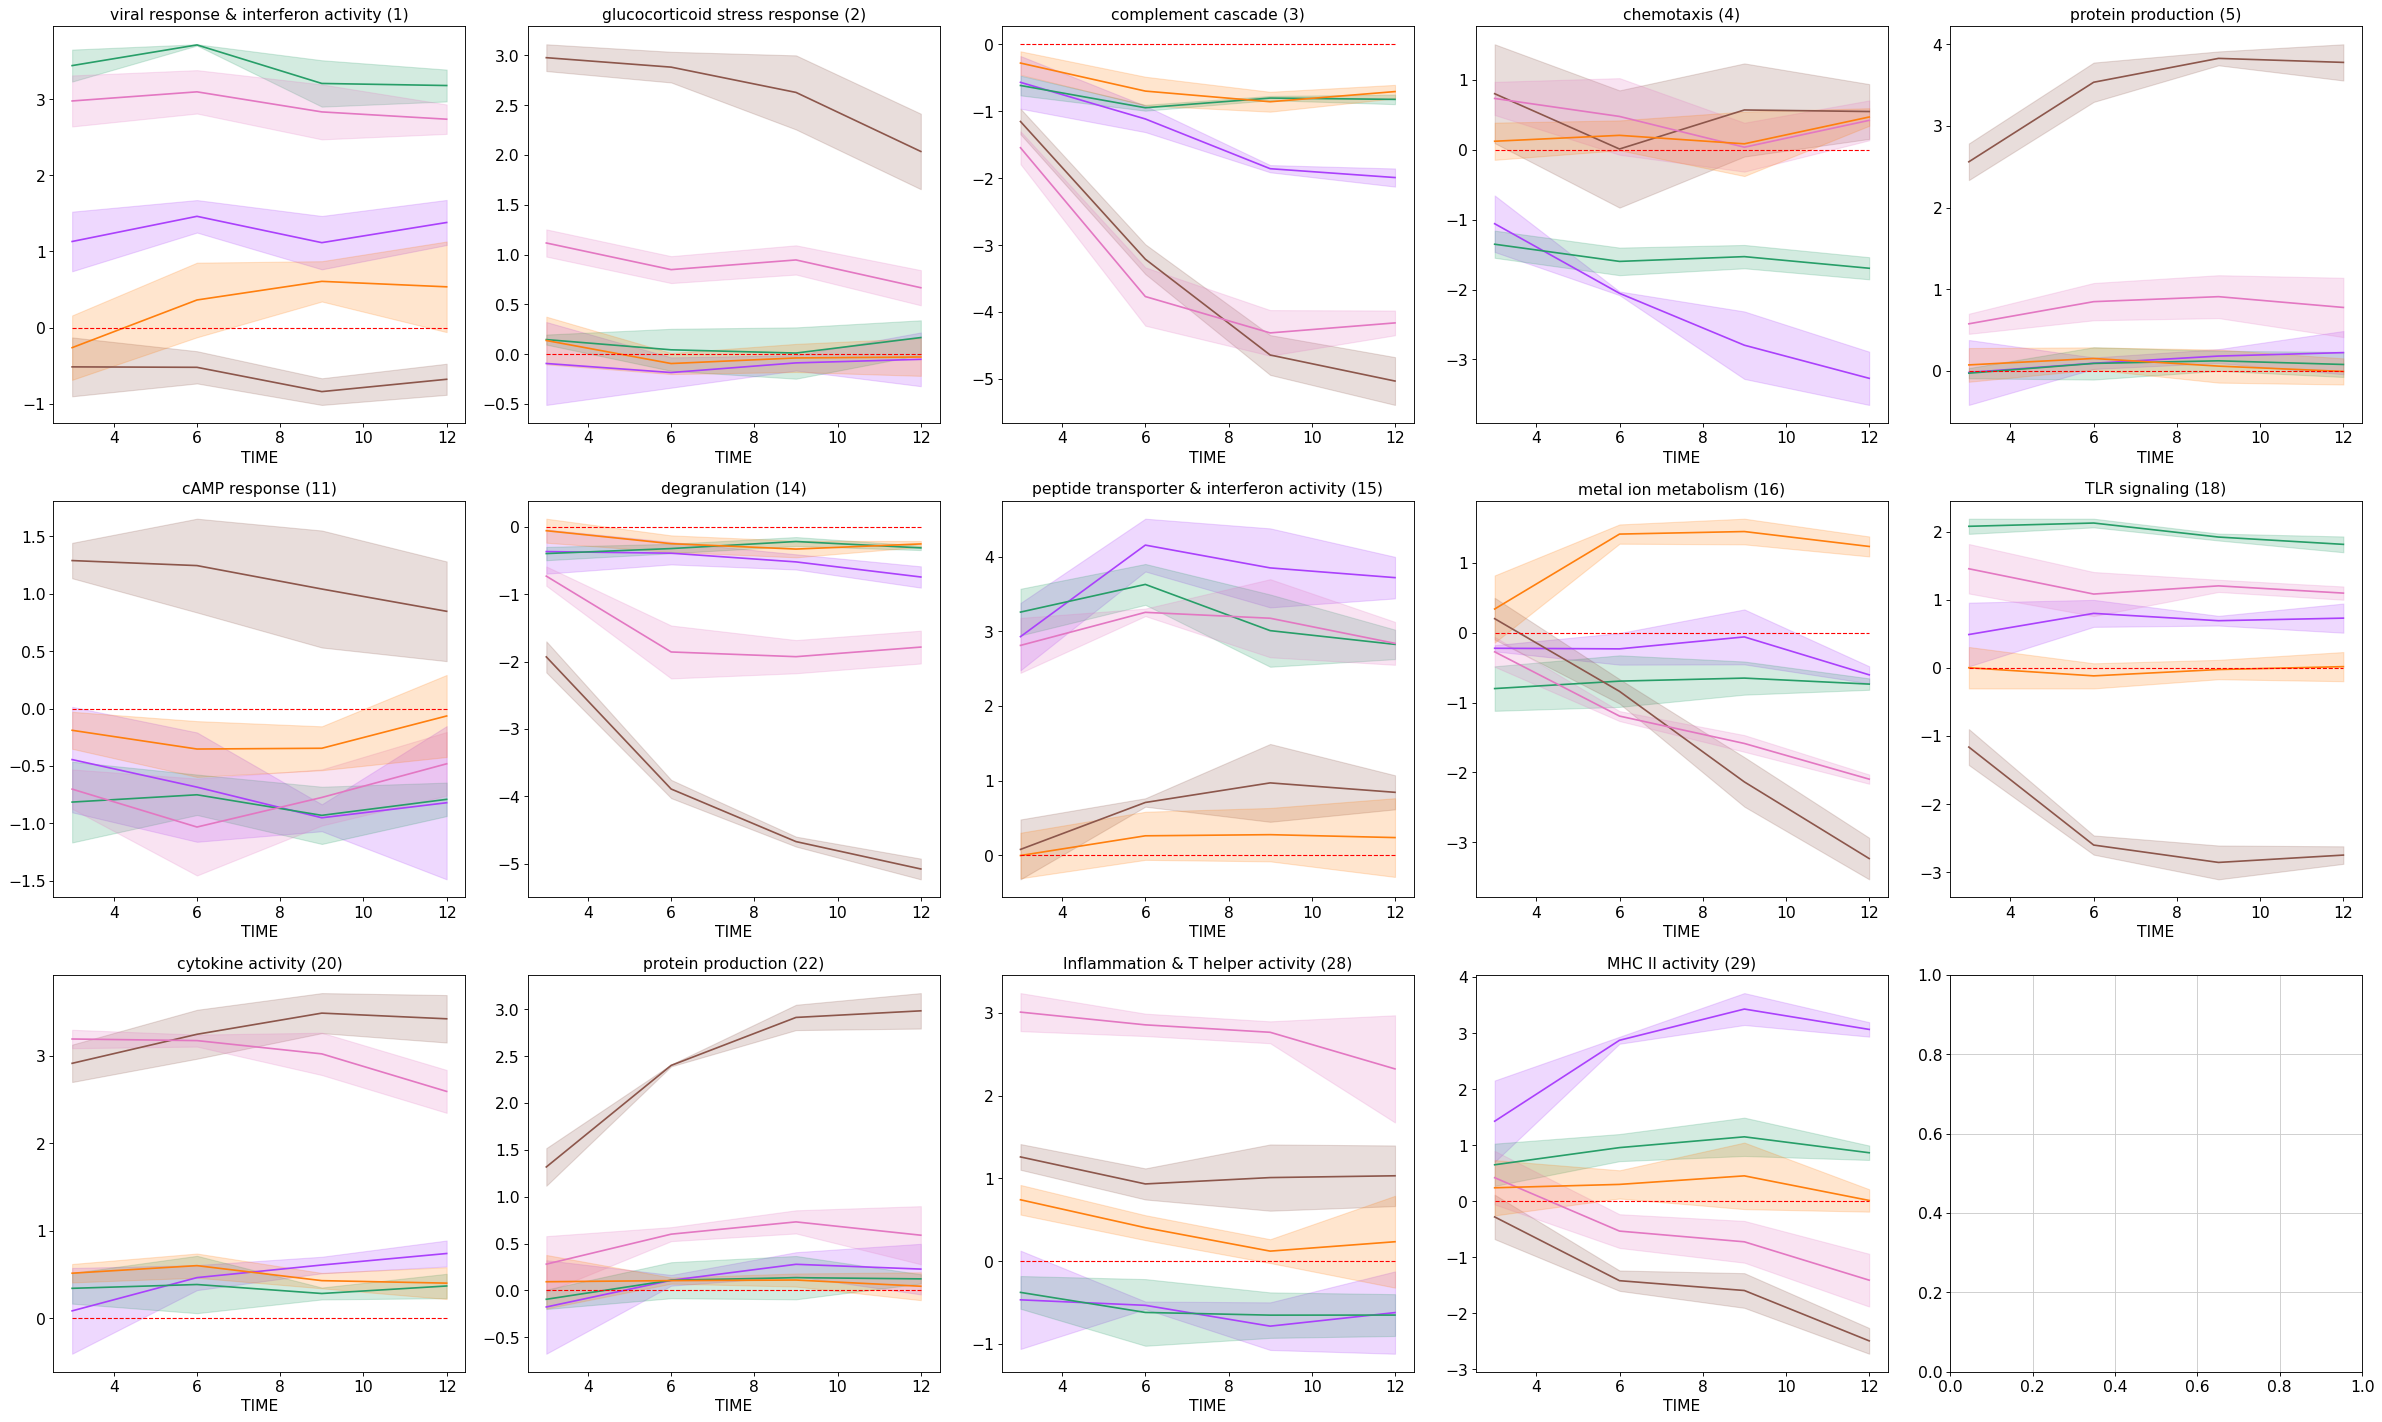

In [121]:
fig, ax = plt.subplots(3, 5, figsize=(30,18))
for sig_module, ax in zip(sig_modules, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm_lfc'][main_modules_genes[sig_module]]#.abs()
    means = specific_counts.mean(1)

    means.rename('Mean Log Fold Change (from Control)', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Log Fold Change (from Control)',data=tidy_means, hue='STIM', err_style="band", ci="sd", ax=ax, palette=cond_long_colors);
    ax.grid(False)
#     ax.set_yscale('log')
    ax.set_ylabel(None)
    ymax = ax.get_ylim()[1]
#     ax.set_ylim((0,ymax))
    ax.set_title(str(sig_module_labels[sig_module]) + ' (' + str(sig_module) + ')')
    ax.get_legend().remove()
    ax.plot([3, 12], [0, 0], linestyle='--', color='r', linewidth=1)
plt.tight_layout()

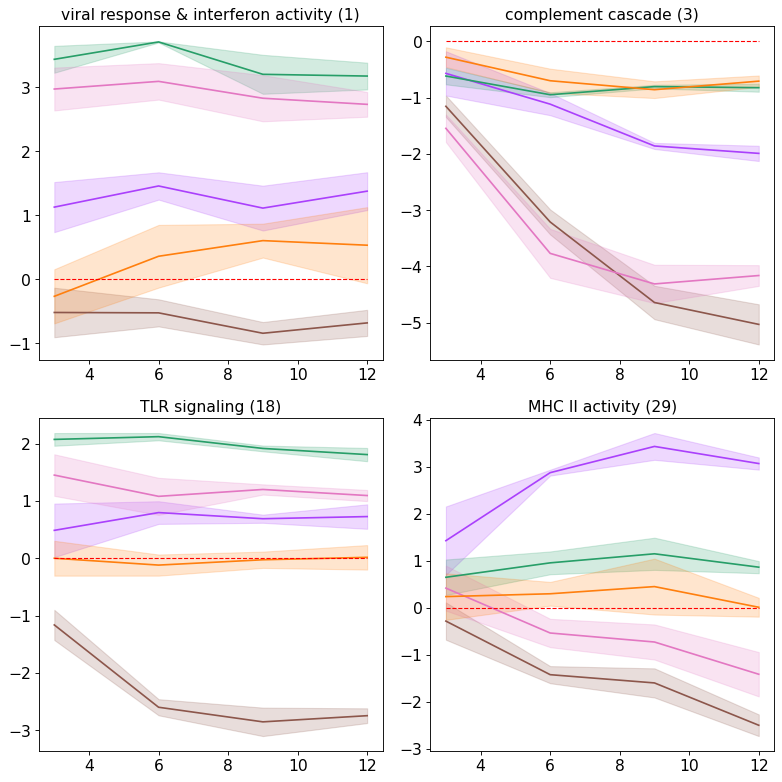

In [122]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for sig_module, ax in zip([1, 3, 18, 29], np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm_lfc'][main_modules_genes[sig_module]]#.abs()
    means = specific_counts.mean(1)

    means.rename('Mean Log Fold Change (from Control)', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Log Fold Change (from Control)',data=tidy_means, hue='STIM', err_style="band", ci="sd", ax=ax, palette=cond_long_colors);
    ax.grid(False)
#     ax.set_yscale('log')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ymax = ax.get_ylim()[1]
#     ax.set_ylim((0,ymax))
    ax.set_title(str(sig_module_labels[sig_module]) + ' (' + str(sig_module) + ')')
    ax.get_legend().remove()
    ax.plot([3, 12], [0, 0], linestyle='--', color='r', linewidth=1)
plt.tight_layout()

## DE Gene Expression Plots

CAUTION: All of the following cells (until the Figures section) uses the `de_genes` object that was created towards the top of this notebook. I made two separate versions, and more can be made using different thresholds for log fold change, significance level, and **_most-importantly_**, whether or not to plot only upregulated genes or both upregulated and downregulated genes. However, **_results will change_** depending on which version of the object is currently loaded, so going back to those cells and re-running them before running the next cells is recommended.

Plotting the mean expression of the genes over time.

First, build a color dictionary to keep the colors consistent between all the plots I will generate. I'm going to use the colors from Scanpy to make it consistent.

In [460]:
counts.keys()

dict_keys(['raw', 'meta', 'norm'])

In [461]:
data_type = 'norm'

In [462]:
stim_values = counts[data_type].index.get_level_values('STIM').unique()
colors = sc.pl.palettes.default_20[:len(stim_values)]

In [463]:
stim_values

Index(['None', 'Control', 'IFNB', 'IFNG', 'PMAI', 'R848', 'TNFa'], dtype='object', name='STIM')

In [464]:
list(zip(range(len(colors)), colors))

[(0, '#1f77b4'),
 (1, '#ff7f0e'),
 (2, '#279e68'),
 (3, '#d62728'),
 (4, '#aa40fc'),
 (5, '#8c564b'),
 (6, '#e377c2')]

In [465]:
stim_values

Index(['None', 'Control', 'IFNB', 'IFNG', 'PMAI', 'R848', 'TNFa'], dtype='object', name='STIM')

In [466]:
color_dict = dict(zip(['None', 'Control', 'IFNB', 'IFNG', 'PMAI', 'R848', 'TNFa'],
                       ['#1f77b4', '#d62728','#279e68','#aa40fc','#8c564b','#e377c2','#ff7f0e'])
                 )

**Mean expression of *time-point specific* DE genes at each time point, relative to control**

To do this using `seaborn`, I'd like to build a `pd.Series` with a multiIndex), then fill it, and then flatten in with `.reset_index()` just before plotting.

In [467]:
idx = list(it.product(stims,['stim','control'],inds, [int(i) for i in hours]))

In [468]:
de_hour = pd.Series(index=pd.MultiIndex.from_tuples(idx,names=['DEGs_FOR', 'SAMPLE', 'IND', 'TIME']), name='Mean Expression')

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Here's a doozy, filling in my Series with many nested for loops.

In [469]:
for stim in tqdm(stims):
    for label in ['stim', 'control']:
        for ind in inds:
            for hour in hours:
                if label == 'stim':
                    sample = stim
                else:
                    sample = 'Control'
                de_hour.loc[(stim, label, ind, int(hour))] = counts[data_type].loc[(counts[data_type].index.get_level_values("IND") == ind) & 
                                                                                   (counts[data_type].index.get_level_values("STIM") == sample) & 
                                                                                   (counts[data_type].index.get_level_values("TIME") == hour),
                                                                                   de_genes[stim][hour]].values.mean()

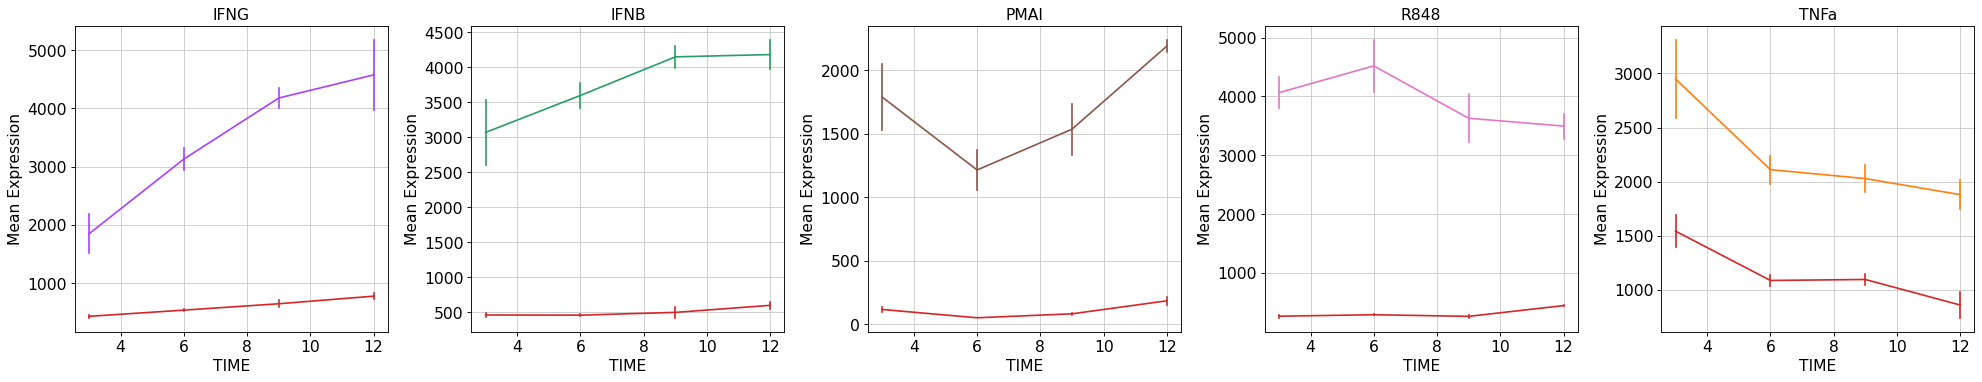

In [470]:
fig, ax = plt.subplots(1,5,figsize=(25,5))
for stim, ax in zip(stims,ax):
    tidy_de_hour = de_hour.reset_index()
    tidy_de_hour = tidy_de_hour[tidy_de_hour['DEGs_FOR'] == stim]
    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_de_hour, hue='SAMPLE', err_style="bars", ci="sd", ax=ax, palette=[color_dict[stim],color_dict['Control']])
    ax.set_title(stim)
    ax.get_legend().remove()
plt.tight_layout()

**Mean expression of *common DE genes* at each time point, relative to control**

Here I choose to either use the union or intersection of genes across all time points. Comment in/out the relative lines of code to get those values.

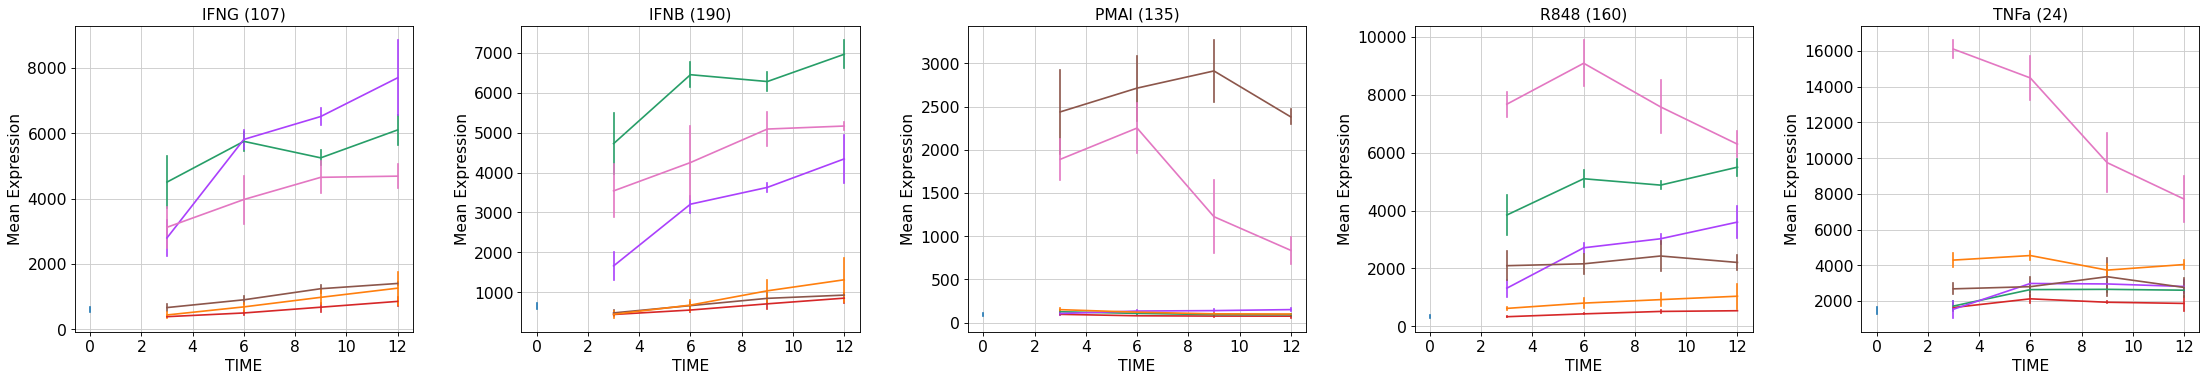

In [471]:
fig, ax = plt.subplots(1, 5, figsize=(28,5))
for stim, ax in zip(stims, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    gene_int = reduce(np.intersect1d, [de_genes[stim][i] for i in hours])
    specific_counts = counts[data_type][gene_int]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(stim + " " + "(" + str(specific_counts.shape[1]) + ")")
    ax.get_legend().remove()
plt.tight_layout()

**Mean expression of *PMAI-specific genes* at each time point, but applied across all time points, relative to control**

I noticed that for PMAI in particular, the genes turned on at 3 hours are turned off at 12 hours, and vice versa. This is not really observed in any of the other stimulation conditions.

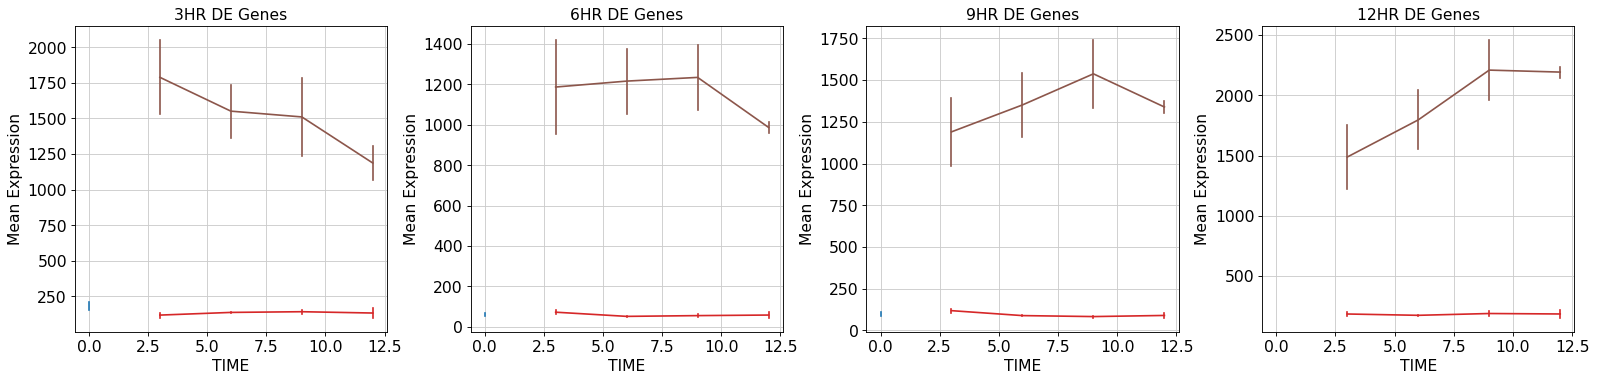

In [472]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
stim = 'PMAI'
for hour, ax in zip(hours, np.ravel(ax)):

    specific_counts = counts[data_type][de_genes[stim][hour]]
    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control') | (tidy_means['STIM'] == 'None')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(hour + "HR DE Genes")
    ax.get_legend().remove()
plt.tight_layout()

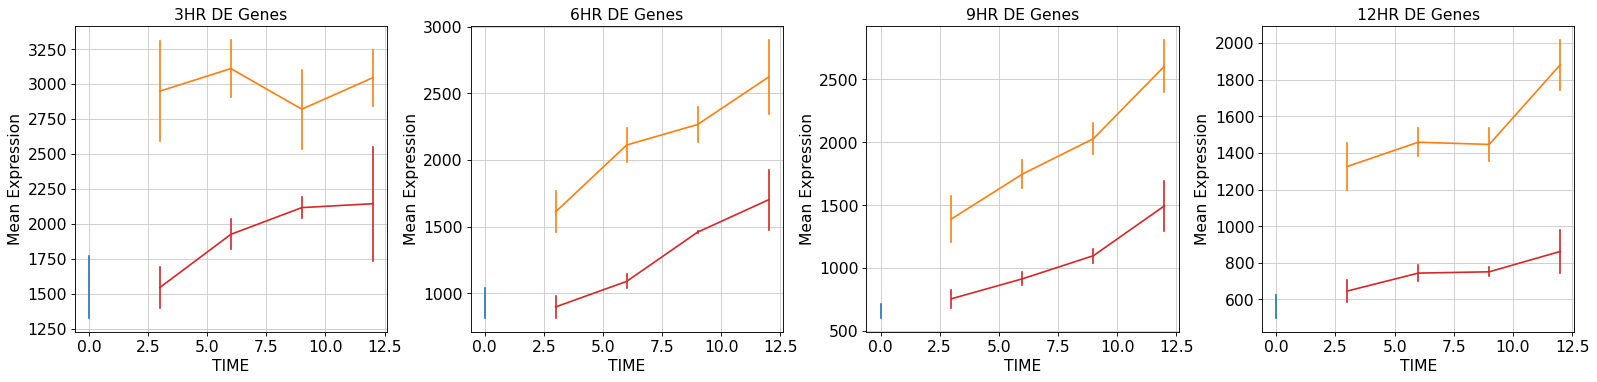

In [473]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
stim = 'TNFa'
for hour, ax in zip(hours, np.ravel(ax)):

    specific_counts = counts[data_type][de_genes[stim][hour]]
    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control') | (tidy_means['STIM'] == 'None')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(hour + "HR DE Genes")
    ax.get_legend().remove()
plt.tight_layout()

### Correlation of Expression of All Genes for Each Stim Relative to Control
I noticed the TNFa response is modest, and the expression values seem to highly correlate with control. Trying to quantify and visualize that here.

Build a list of the pearson R values between each stim and the common control, for all **12** individual- and time-matched samples.

In [474]:
pearsons = list()
for stim in stims:
    df = counts[data_type][(counts[data_type].index.get_level_values("STIM") == stim) | (counts[data_type].index.get_level_values("STIM") == 'Control')]
    myiter = df.iterrows()
    for _ in range(12):
        x = next(myiter)
        y = next(myiter)
        
        arr = np.array(list(zip(x[1].values, y[1].values)))
        arr = arr[arr.sum(1) != 0]
        
        pearsons.append([stim,np.corrcoef(arr, rowvar=False)[0,1]])

In [475]:
pearsons = pd.DataFrame(pearsons,columns = ['stim','r'])

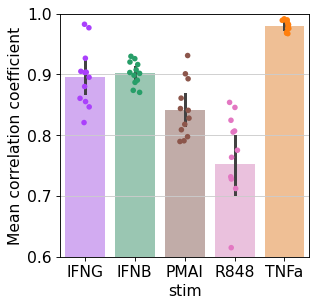

In [476]:
ax = sns.stripplot(data=pearsons,x='stim',y='r',palette=color_dict,);
ax = sns.barplot(data=pearsons,x='stim',y='r',palette=color_dict, alpha=0.5, ax=ax);
plt.ylim(0.6,1);
plt.ylabel('Mean correlation coefficient');

### Gene Ontology Analysis

In [477]:
obo_fname = download_go_basic_obo(prefix + "go-basic.obo")
fin_gene2go = download_ncbi_associations(prefix + 'gene2go')

  EXISTS: /data/codec/bulk.jan20/go-basic.obo
  EXISTS: /data/codec/bulk.jan20/gene2go


In [478]:
obodag = GODag(prefix + "go-basic.obo")

/data/codec/bulk.jan20/go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms


In [479]:
# Read NCBI's gene2go. Store annotations in a list of named tuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:04.595826 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: /data/codec/bulk.jan20/gene2go 
CC 18,648 annotated human genes
BP 17,541 annotated human genes
MF 17,384 annotated human genes


In [480]:
gene_ids = list(GeneID2nt_hum.keys())
symbol2geneid = dict(zip([GeneID2nt_hum[i].Symbol for i in gene_ids], [i for i in gene_ids]))

Selecting a few samples that look like they may reveal the most interesting biology.

In [481]:
stim_hours = [('IFNG','9'), ('IFNB', '9'), ('PMAI', '3'), ('PMAI', '12'), ('R848', '6'), ('TNFa','3')]

Next cell produces a lot of output, recommend collapsing it in notebook.

In [482]:
results = list()
for stim, hour in tqdm(stim_hours):
    ids = list()
    for i in de_genes[stim][hour]:
        try:
            ids.append(symbol2geneid[i])
        except:
            continue
    print(len(ids)/len(de_genes[stim][hour]))
    
    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method
    
    goea_results_all = goeaobj.run_study(ids)
    for i in goea_results_all:
        results.append([stim + ", " + hour, i.name, i.NS, -np.log10(i.p_fdr_bh)])

0.9250936329588015

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association

Run BP Gene Ontology Analysis: current study set of 247 IDs ... 96%    238 of    247 study items found in association
100%    247 of    247 study items found in population(20913)
Calculating 12,176 uncorrected p-values using fisher_scipy_stats
  12,176 GO terms are associated with 16,711 of 20,913 population items
   1,748 GO terms are associated with    238 of    247 study items
  METHOD fdr_bh:
      57 GO terms found significant (< 0.05=alpha) ( 57 enriched +   0 purified

In [491]:
results_df = pd.DataFrame(results, columns=['Sample','GO_term','GO_type','-log10padj'])

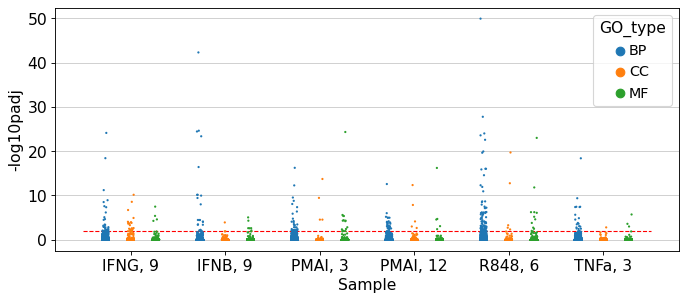

In [492]:
plt.figure(figsize=(10,4))
sns.stripplot(data=results_df,x='Sample', hue='GO_type', y='-log10padj', dodge=True, size=2);
plt.plot([-0.5,5.5],[-np.log10(0.01)]*2, linestyle='--', linewidth=1, color='r');

### Print out GO Analysis Results

In [493]:
from IPython.display import display # need this to print out the results without truncation.

In [494]:
sample = 'TNFa, 3' # input whichever sample you'd like here

In [495]:
df = results_df[(results_df['-log10padj'] > -np.log10(0.01)) &
                (results_df['Sample'] == sample)
               ][['GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False)
with pd.option_context('display.max_rows', 120, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(df)

,GO_type,GO_term,-log10padj
104232,MF,chemokine activity,5.702485
104233,MF,identical protein binding,3.588802
104234,MF,CCR chemokine receptor binding,2.985992
102501,CC,membrane raft,2.785704
90325,BP,inflammatory response,18.385375
90326,BP,neutrophil chemotaxis,9.366797
90327,BP,cytokine-mediated signaling pathway,7.441759
90328,BP,apoptotic process,7.441759
90329,BP,cellular response to lipopolysaccharide,7.376679
90330,BP,lipopolysaccharide-mediated signaling pathway,7.376679


### Highlight Some GO Terms

In [496]:
highlight = ['immune response', 
             'inflammatory response', 
             'interferon-gamma-mediated signaling pathway',
             'type I interferon signaling pathway',
             'defense response to virus',
             'cytokine activity',
             'neutrophil chemotaxis',
             'innate immune response',
             'response to interferon-beta',
             'positive regulation of NF-kappaB transcription factor activity',
             'positive regulation of cell population proliferation'
            ]

In [497]:
results_df_no_time = results_df.copy()
results_df_no_time['Sample'] = list(map(lambda x: x[0], results_df_no_time['Sample'].str.split(', ')))

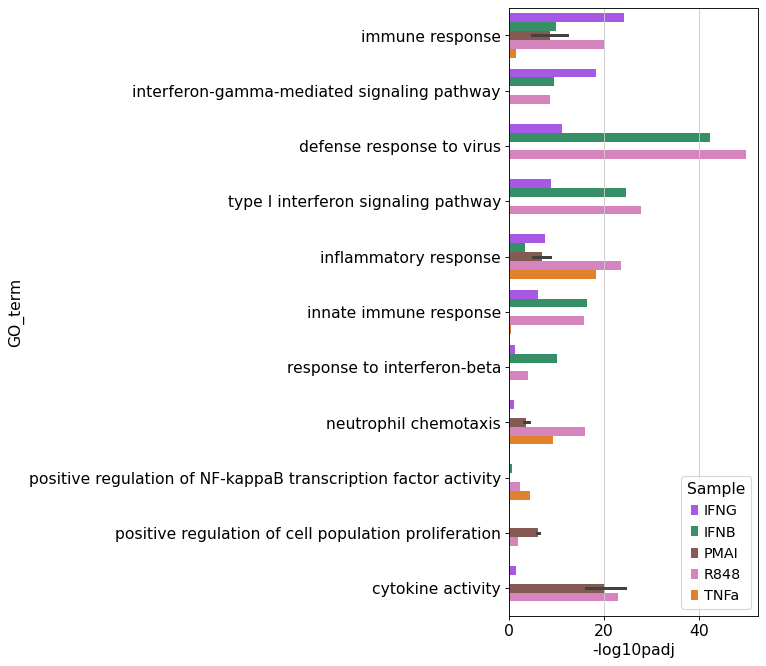

In [498]:
plt.figure(figsize=(4,10))
sns.barplot(data=results_df_no_time[results_df_no_time['GO_term'].isin(highlight)],
            orient="h", x="-log10padj", y='GO_term', hue='Sample', palette=color_dict);

### Compare GO Results between Two PMAI Responses

In [125]:
pmai3 = results_df[(results_df['Sample'] == ('PMAI, 3')) & (results_df['-log10padj'] > -np.log10(0.05))]
pmai12 = results_df[(results_df['Sample'] == ('PMAI, 12')) & (results_df['-log10padj'] > -np.log10(0.05))]

In [126]:
pmai3_diff = np.setdiff1d(pmai3['GO_term'].values,pmai12['GO_term'].values)

In [127]:
pmai12_diff = np.setdiff1d(pmai12['GO_term'].values,pmai3['GO_term'].values)

In [128]:
with pd.option_context('display.max_rows', 120, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(pmai3[(pmai3['GO_term'].isin(pmai3_diff)) & (pmai3['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False))

,Sample,GO_term,GO_type,-log10padj
36137,"PMAI, 3",positive regulation of transcription by RNA polymerase II,BP,5.878226
36139,"PMAI, 3",myeloid dendritic cell differentiation,BP,4.218051
36141,"PMAI, 3",negative regulation of transcription by RNA polymerase II,BP,3.970814
36147,"PMAI, 3",signal transduction,BP,2.799795
36149,"PMAI, 3",positive regulation of smooth muscle cell proliferation,BP,2.411710
36151,"PMAI, 3",activation of MAPKKK activity,BP,2.268175
36153,"PMAI, 3",regulation of cell adhesion,BP,2.192337
36154,"PMAI, 3",negative regulation of immune response,BP,2.168154
36155,"PMAI, 3",skeletal muscle cell differentiation,BP,2.121338
36156,"PMAI, 3",cellular response to corticotropin-releasing hormone stimulus,BP,2.121338


In [129]:
with pd.option_context('display.max_rows', 120, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(pmai12[(pmai12['GO_term'].isin(pmai12_diff)) & (pmai12['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False))

,Sample,GO_term,GO_type,-log10padj
54202,"PMAI, 12",rRNA processing,BP,4.041132
54219,"PMAI, 12",focal adhesion assembly,BP,2.371660
54220,"PMAI, 12",positive regulation of T-helper 17 cell lineage commitment,BP,1.921491
54222,"PMAI, 12",osteoblast differentiation,BP,1.919213
54223,"PMAI, 12",extracellular matrix organization,BP,1.914252
54224,"PMAI, 12",positive regulation of granulocyte macrophage colony-stimulating factor production,BP,1.837891
54227,"PMAI, 12",positive regulation of NK T cell activation,BP,1.658726
54228,"PMAI, 12",regulation of tyrosine phosphorylation of STAT protein,BP,1.658726
54231,"PMAI, 12",positive regulation of protein kinase B signaling,BP,1.658273
54232,"PMAI, 12",decidualization,BP,1.645445


# Figures

In [138]:
fig_prefix = '/data/codec/figs/bulk/'

In [163]:
filename = fig_prefix + 'heatmap.jaccard.de.gene.sets.cond.time.png'
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.xaxis.tick_top()
ax.yaxis.tick_right()
sns.heatmap(overlap, mask=mask, ax=ax, cbar=None);
plt.title('Jaccard Index of Gene Sets\nDifferentially Expressed from Control')
plt.xticks(rotation=45, ha='left');
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()

In [162]:
filename = fig_prefix + 'lines.time.specific.de.genes.png'
fig, axs = plt.subplots(1,5,figsize=(25,4.25))
axs[2].text(0.5, 1.15, 'Expression of Time-point-specific Differentially-expressed Genes\nat each Time Point Compared to Control', fontsize=18, transform=axs[2].transAxes, ha='center')
for stim, ax in zip(stims,axs):
    tidy_de_hour = de_hour.reset_index()
    tidy_de_hour = tidy_de_hour[tidy_de_hour['DEGs_FOR'] == stim]
    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_de_hour, hue='SAMPLE', err_style="bars", ci="sd", ax=ax, palette=[color_dict[stim],color_dict['Control']])
    ax.set_title(stim)
    ax.get_legend().remove()
for ax in axs[1:]:
    ax.set_ylabel(None)
plt.savefig(filename, dpi=80)
plt.close()

In [194]:
filename = fig_prefix + 'barplot.GO.terms.png'
plt.figure(figsize=(10,20))
sns.barplot(data=results_df_no_time[results_df_no_time['GO_term'].isin(highlight)],
            orient="h", x="-log10padj", y='GO_term', hue='Sample', palette=color_dict);
ax = plt.gca()
texts = [i.get_text() for i in ax.get_yticklabels()]

texts[texts.index('interferon-gamma-mediated signaling pathway')] = 'interferon-gamma-mediated\nsignaling pathway'
texts[texts.index('positive regulation of NF-kappaB transcription factor activity')] = 'positive regulation of NF-kappaB\ntranscription factor activity'
texts[texts.index('positive regulation of cell population proliferation')] = 'positive regulation of\ncell population proliferation'

ax.set_yticklabels(texts);
ax.set_ylabel('GO Term');
ax.set_title('Enrichment of GO Terms in\nStimulation Conditions');
plt.tight_layout()
plt.savefig(filename, dpi=80)
plt.close()